## Reading the data files

### Importing required libraries

In [24]:
!pip install pmdarima --quiet

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pickle
import pmdarima

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import LogEndogTransformer, BoxCoxEndogTransformer
from pmdarima.arima import ARIMA
from datetime import datetime, timedelta

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.7 MB/s eta 0:00:00


### Reading the dataset

In [4]:
data = pd.read_csv('/content/drive/MyDrive/train.csv')

In [5]:
data

ID_Date StateCode  StationId        Date    PM2.5      PM10  \
0       AS_4_2021-08-17        AS          4  2021-08-17  51.8364  120.3702   
1       AS_4_2021-08-18        AS          4  2021-08-18  59.4762   87.0978   
2       AS_4_2021-08-19        AS          4  2021-08-19  61.0776   79.6008   
3       AS_4_2021-08-20        AS          4  2021-08-20  56.7222   94.2072   
4       AS_4_2021-08-21        AS          4  2021-08-21  85.3332  136.7820   
...                 ...       ...        ...         ...      ...       ...   
25335  WB_16_2022-11-29        WB         16  2022-11-29  16.3275   33.8940   
25336  WB_16_2022-11-30        WB         16  2022-11-30  15.2880   29.9145   
25337  WB_16_2022-12-01        WB         16  2022-12-01  14.1015   31.1325   
25338  WB_16_2022-12-02        WB         16  2022-12-02  17.8605   30.5340   
25339  WB_16_2022-12-03        WB         16  2022-12-03  16.6215   28.8750   

            O3       CO      SO2    AQI  
0      18.0234  0.48960  14.3106   94.0  
1      34.5270  0.47940  14.7594  124.0  
2      42.0546  0.52020  16.7484   82.0  
3      45.7878  0.49980  27.6114  107.0  
4      44.5638  1.11180  26.4180  107.0  
...        ...      ...      ...    ...  
25335  36.5190  0.65100   3.5490   47.0  
25336  37.2225  0.63525   2.9400   52.0  
25337  27.1845  0.67200   5.4285   41.0  
25338  30.0510  0.59850   7.4235   40.0  
25339  37.2120  0.66150  11.3190   48.0  

[25340 rows x 10 columns]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25340 entries, 0 to 25339
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID_Date    25340 non-null  object 
 1   StateCode  25340 non-null  object 
 2   StationId  25340 non-null  int64  
 3   Date       25340 non-null  object 
 4   PM2.5      25339 non-null  float64
 5   PM10       25338 non-null  float64
 6   O3         25324 non-null  float64
 7   CO         25339 non-null  float64
 8   SO2        25340 non-null  float64
 9   AQI        25340 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 1.9+ MB


In [7]:
data['StateCode'].unique()

array(['AS', 'DL', 'KA', 'MH', 'TN', 'WB'], dtype=object)

In [8]:
data['Date'] = pd.to_datetime(data['Date'])

In [9]:
data.isnull().sum()

ID_Date       0
StateCode     0
StationId     0
Date          0
PM2.5         1
PM10          2
O3           16
CO            1
SO2           0
AQI           0
dtype: int64

In [10]:
data['Date'] = pd.to_datetime(data['Date'])

def imputation_mean(data, column, mean):
  data[column] = data[column].fillna(mean)
  return data

cols = ['PM2.5', 'PM10', 'O3', 'CO']
for c in cols:
  mean = data[c].mean()
  data = imputation_mean(data, c, mean)

data.isnull().sum()

ID_Date      0
StateCode    0
StationId    0
Date         0
PM2.5        0
PM10         0
O3           0
CO           0
SO2          0
AQI          0
dtype: int64

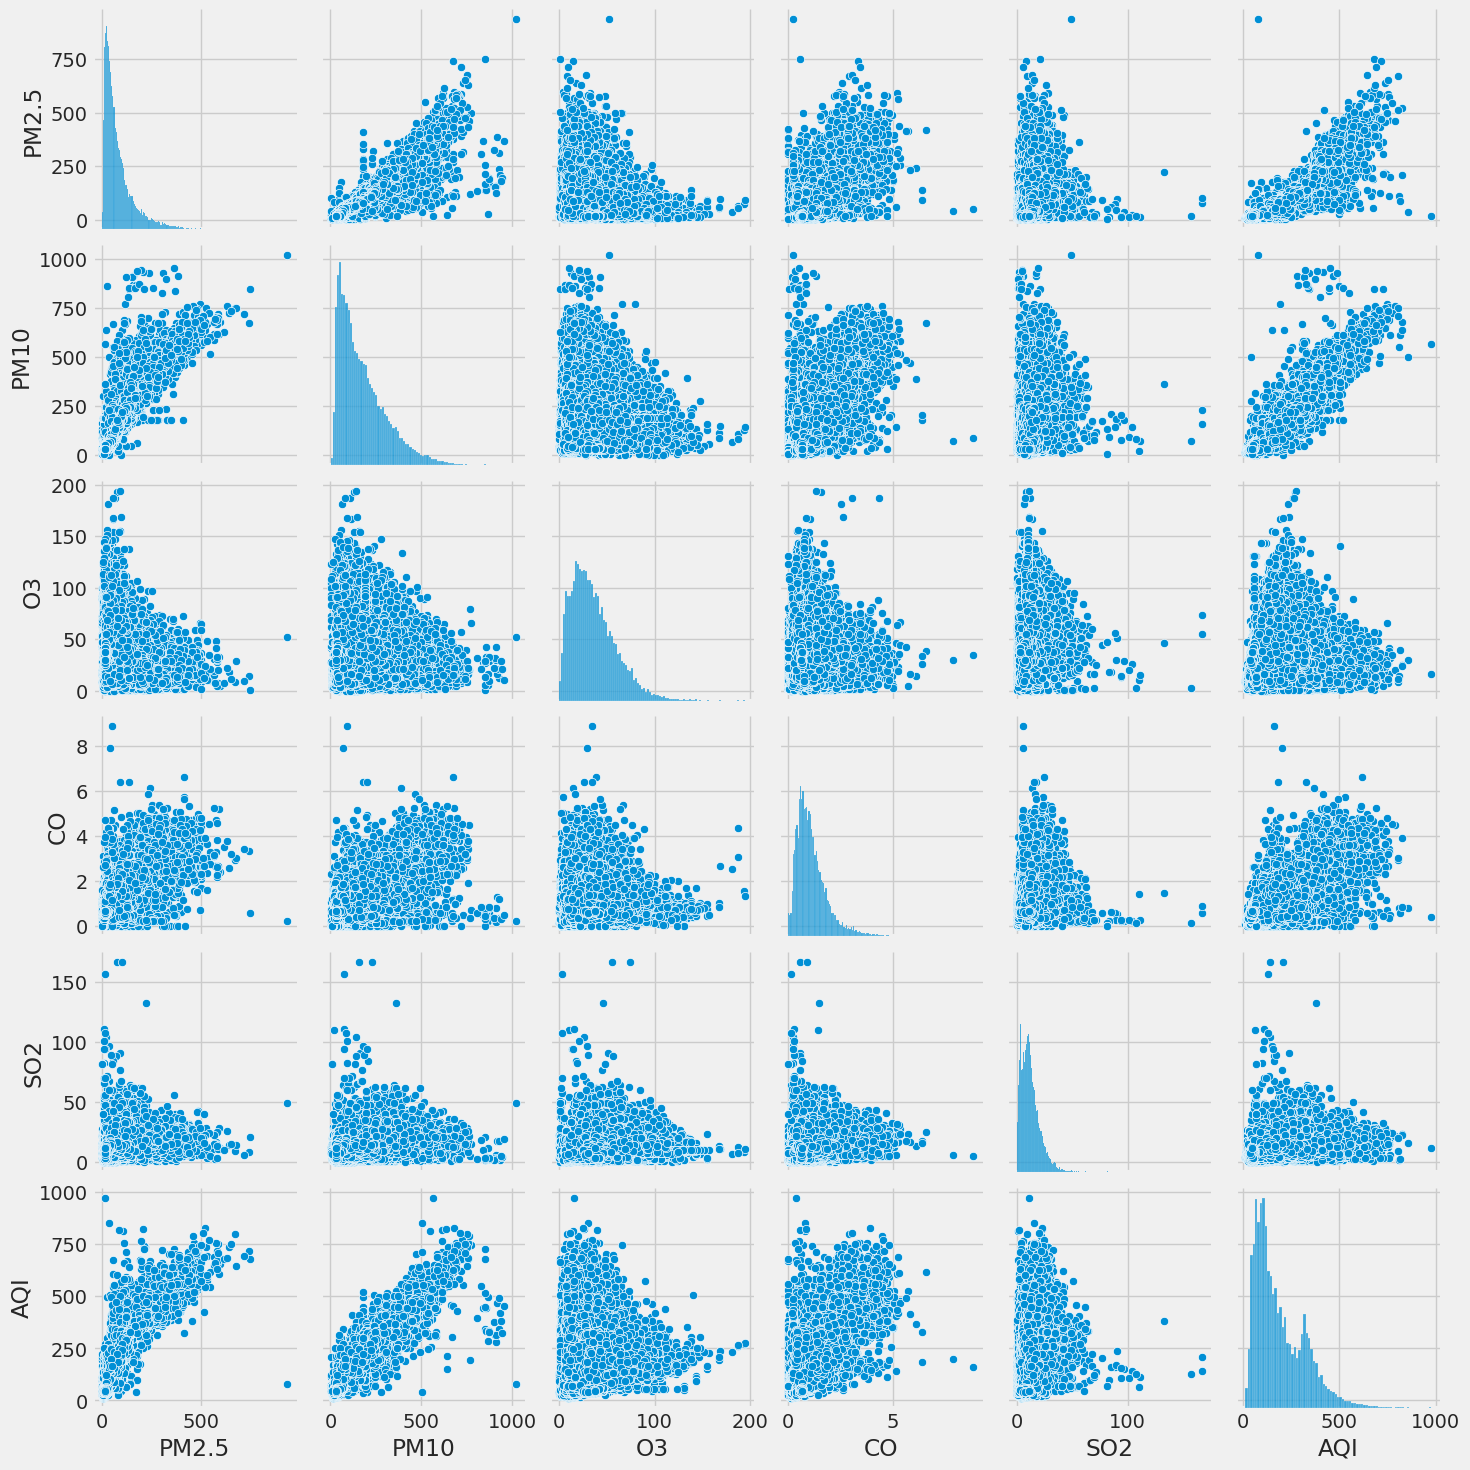

In [11]:
sns.pairplot(data=data[['PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'AQI']])

In [12]:
# Create new features for year, month, and day
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

#Label Encoding for 'State'
# le = LabelEncoder()
# data['StateCode'] = le.fit_transform(data['StateCode'])

In [13]:
data.describe()

StationId         PM2.5          PM10            O3            CO  \
count  25340.000000  25340.000000  25340.000000  25340.000000  25340.000000   
mean      19.700552     84.722233    176.876226     36.328698      1.135535   
std       11.000809     80.603667    131.998470     23.349097      0.759955   
min        4.000000      0.199500      0.220500      0.052500      0.000000   
25%       11.000000     30.280000     73.754650     18.655800      0.612000   
50%       16.000000     58.028900    142.532200     31.980000      0.969000   
75%       29.000000    109.163250    247.206000     49.592400      1.459500   
max       41.000000    935.003400   1020.000000    194.146800      8.863800   

                SO2           AQI          Year         Month           Day  
count  25340.000000  25340.000000  25340.000000  25340.000000  25340.000000  
mean      12.531818    190.841555   2021.433820      6.710616     15.442265  
std        8.917706    127.643584      0.652796      3.391365      8.647530  
min        0.010500     14.000000   2020.000000      1.000000      1.000000  
25%        6.293400     91.000000   2021.000000      4.000000      8.000000  
50%       10.830000    152.000000   2022.000000      7.000000     15.000000  
75%       16.605600    276.000000   2022.000000     10.000000     23.000000  
max      166.943400    975.000000   2022.000000     12.000000     31.000000

EPA's PM10 Breakpoints

<hr>

|  | AQI | PM10 |
| :---: | :---: | :--: |
| Good	| 0-50 |	0-54 |
| Moderate	| 51-100 |	55-154
| Unhealthy for sensitive individuals	| 101-150 | 155-254
| Unhealthy	| 151-200 | 255-354
| Very unhealthy	| 201-300	| 355-424
| Hazardous	 |301-400 | 425-504
| Hazardous	 |401-500	| 505-604
| Hazardous	 |501-999	| 605-9999

</hr>

## Visualization of trends

<Figure size 1400x600 with 0 Axes>

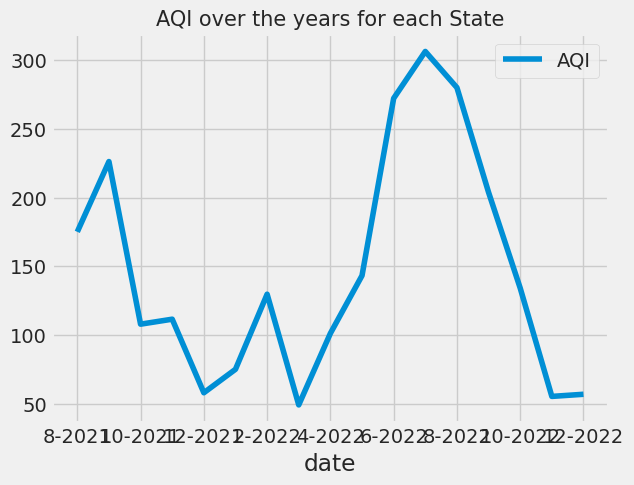

<Figure size 1400x600 with 0 Axes>

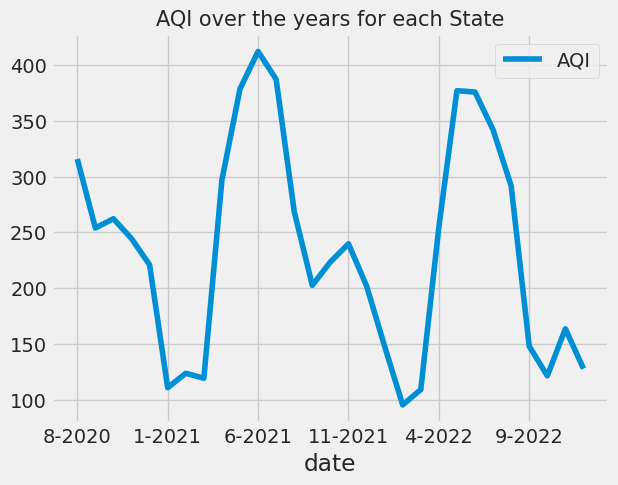

<Figure size 1400x600 with 0 Axes>

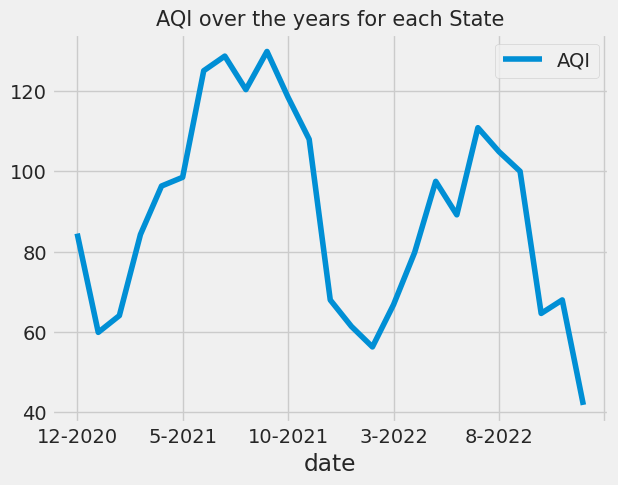

<Figure size 1400x600 with 0 Axes>

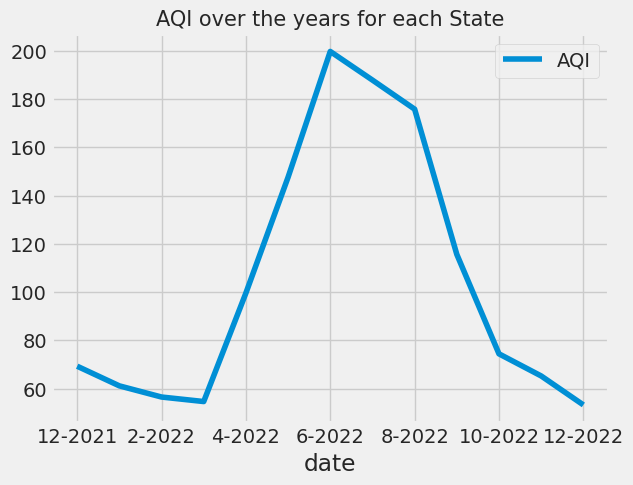

<Figure size 1400x600 with 0 Axes>

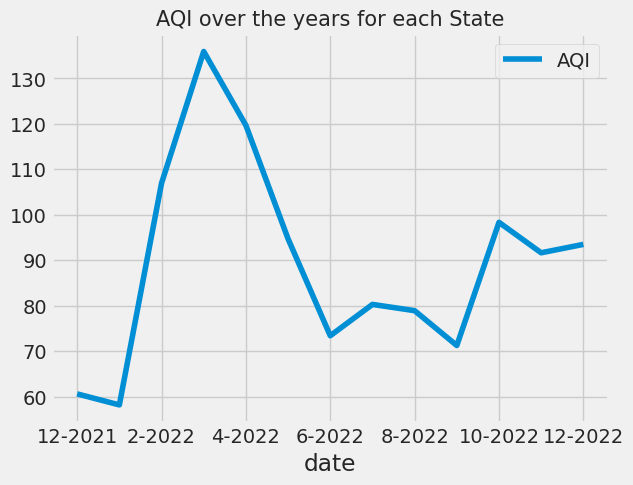

<Figure size 1400x600 with 0 Axes>

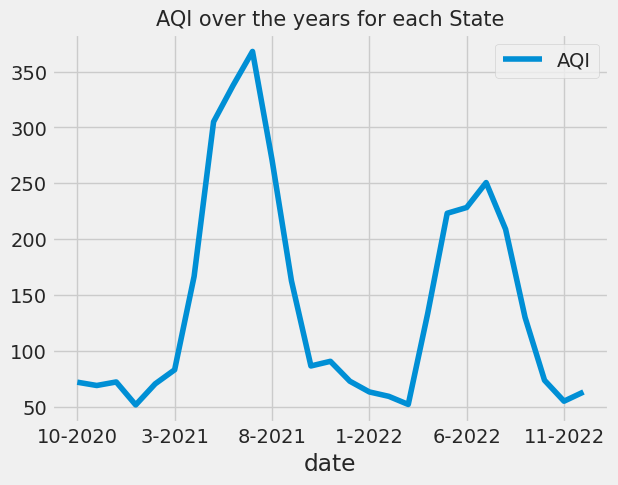

In [14]:
def visualize_aqi_trend(sub_data_by_year):
  plt.figure(figsize=(14,6))
  sub_data_by_year.plot(kind = 'line', x= 'date', y = 'AQI')
  plt.title('AQI over the years for each State', fontsize=15)
  
def aqi_trend(sub_data):
  sub_data_by_year = sub_data.groupby(['Year', 'Month'], as_index = False).AQI.mean()
  cols=["Month", "Year"]
  sub_data_by_year['date'] = sub_data_by_year[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
  # print(sub_data_by_year)
  visualize_aqi_trend(sub_data_by_year)
  
for state in data['StateCode'].unique():
  sub_data = data[data['StateCode'] == state]
  # print(sub_data)
  aqi_trend(sub_data)

<Axes: xlabel='Month', ylabel='AQI'>

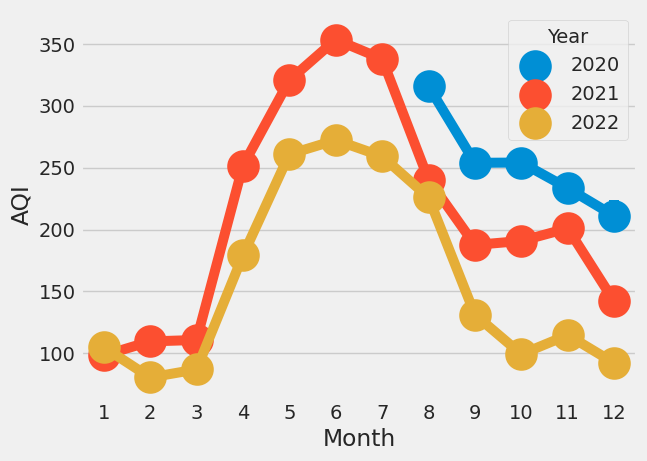

In [15]:
sns.pointplot(x='Month',y='AQI',hue='Year',data=data)

<Axes: xlabel='StateCode', ylabel='AQI'>

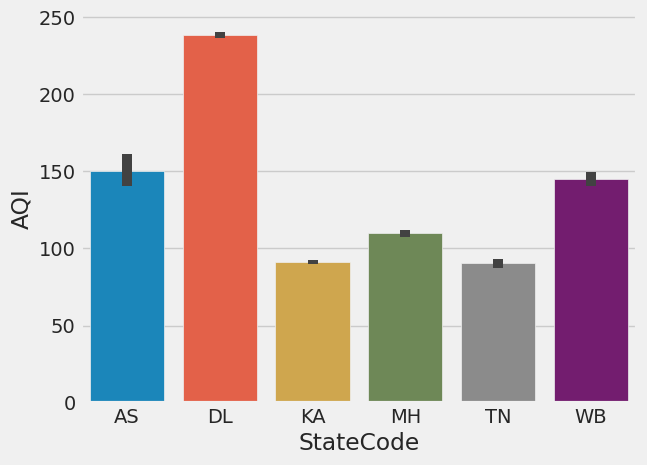

In [16]:
sns.barplot(x='StateCode',y='AQI',data=data)

## Modeling ARIMA with Box-Cox Transformation

### Scaling the data

In [19]:
scaler = StandardScaler()
data[['PM2.5', 'PM10', 'CO', 'O3', 'SO2']] = scaler.fit_transform(data[['PM2.5', 'PM10', 'CO', 'O3', 'SO2']])
data

ID_Date StateCode  StationId       Date     PM2.5      PM10  \
0       AS_4_2021-08-17        AS          4 2021-08-17 -0.408002 -0.428089   
1       AS_4_2021-08-18        AS          4 2021-08-18 -0.313218 -0.680161   
2       AS_4_2021-08-19        AS          4 2021-08-19 -0.293350 -0.736958   
3       AS_4_2021-08-20        AS          4 2021-08-20 -0.347386 -0.626300   
4       AS_4_2021-08-21        AS          4 2021-08-21  0.007580 -0.303754   
...                 ...       ...        ...        ...       ...       ...   
25335  WB_16_2022-11-29        WB         16 2022-11-29 -0.848548 -1.083233   
25336  WB_16_2022-11-30        WB         16 2022-11-30 -0.861445 -1.113381   
25337  WB_16_2022-12-01        WB         16 2022-12-01 -0.876165 -1.104154   
25338  WB_16_2022-12-02        WB         16 2022-12-02 -0.829529 -1.108688   
25339  WB_16_2022-12-03        WB         16 2022-12-03 -0.844900 -1.121257   

             O3        CO       SO2    AQI  Year  Month  Day  
0     -0.783999 -0.849982  0.199470   94.0  2021      8   17  
1     -0.077165 -0.863404  0.249798  124.0  2021      8   18  
2      0.245235 -0.809716  0.472842   82.0  2021      8   19  
3      0.405124 -0.836560  1.691004  107.0  2021      8   20  
4      0.352702 -0.031233  1.557178  107.0  2021      8   21  
...         ...       ...       ...    ...   ...    ...  ...  
25335  0.008150 -0.637597 -1.007321   47.0  2022     11   29  
25336  0.038281 -0.658322 -1.075614   52.0  2022     11   30  
25337 -0.391637 -0.609963 -0.796557   41.0  2022     12    1  
25338 -0.268868 -0.706681 -0.572840   40.0  2022     12    2  
25339  0.037831 -0.623780 -0.136004   48.0  2022     12    3  

[25340 rows x 13 columns]

### Feature engineering

In [20]:
data['State_Station']= data['StateCode'].astype(str) + "_" + data['StationId'].astype(str)
data

ID_Date StateCode  StationId       Date     PM2.5      PM10  \
0       AS_4_2021-08-17        AS          4 2021-08-17 -0.408002 -0.428089   
1       AS_4_2021-08-18        AS          4 2021-08-18 -0.313218 -0.680161   
2       AS_4_2021-08-19        AS          4 2021-08-19 -0.293350 -0.736958   
3       AS_4_2021-08-20        AS          4 2021-08-20 -0.347386 -0.626300   
4       AS_4_2021-08-21        AS          4 2021-08-21  0.007580 -0.303754   
...                 ...       ...        ...        ...       ...       ...   
25335  WB_16_2022-11-29        WB         16 2022-11-29 -0.848548 -1.083233   
25336  WB_16_2022-11-30        WB         16 2022-11-30 -0.861445 -1.113381   
25337  WB_16_2022-12-01        WB         16 2022-12-01 -0.876165 -1.104154   
25338  WB_16_2022-12-02        WB         16 2022-12-02 -0.829529 -1.108688   
25339  WB_16_2022-12-03        WB         16 2022-12-03 -0.844900 -1.121257   

             O3        CO       SO2    AQI  Year  Month  Day State_Station  
0     -0.783999 -0.849982  0.199470   94.0  2021      8   17          AS_4  
1     -0.077165 -0.863404  0.249798  124.0  2021      8   18          AS_4  
2      0.245235 -0.809716  0.472842   82.0  2021      8   19          AS_4  
3      0.405124 -0.836560  1.691004  107.0  2021      8   20          AS_4  
4      0.352702 -0.031233  1.557178  107.0  2021      8   21          AS_4  
...         ...       ...       ...    ...   ...    ...  ...           ...  
25335  0.008150 -0.637597 -1.007321   47.0  2022     11   29         WB_16  
25336  0.038281 -0.658322 -1.075614   52.0  2022     11   30         WB_16  
25337 -0.391637 -0.609963 -0.796557   41.0  2022     12    1         WB_16  
25338 -0.268868 -0.706681 -0.572840   40.0  2022     12    2         WB_16  
25339  0.037831 -0.623780 -0.136004   48.0  2022     12    3         WB_16  

[25340 rows x 14 columns]

### Checking for stationarity

In [21]:
non_stationary_state_station = []

for state in data['StateCode'].unique():
  state_data = data[data['StateCode'] == state]
  for station in state_data['StationId'].unique():  
    state_station_data = state_data[state_data['StationId'] == station]
    result = adfuller(state_station_data['AQI'])
    # print('ADF Statistic: %f' % result[0])
    # print('p-value: %f' % result[1])
    # print('Critical Values:')
    # for key, value in result[4].items():
    #   print('\t%s: %.3f' % (key, value))
    if result[1] > 0.05:
      non_stationary_state_station.append(str(state) + "_" + str(station))

In [22]:
non_stationary_state_station = sorted(non_stationary_state_station)
non_stationary_state_station

['DL_18',
 'DL_26',
 'DL_32',
 'DL_38',
 'DL_39',
 'DL_8',
 'KA_10',
 'KA_7',
 'MH_10',
 'MH_11',
 'MH_12',
 'MH_13',
 'MH_14',
 'MH_15',
 'MH_16',
 'MH_17',
 'WB_12',
 'WB_13',
 'WB_14',
 'WB_16']

### Checking the order of differencing

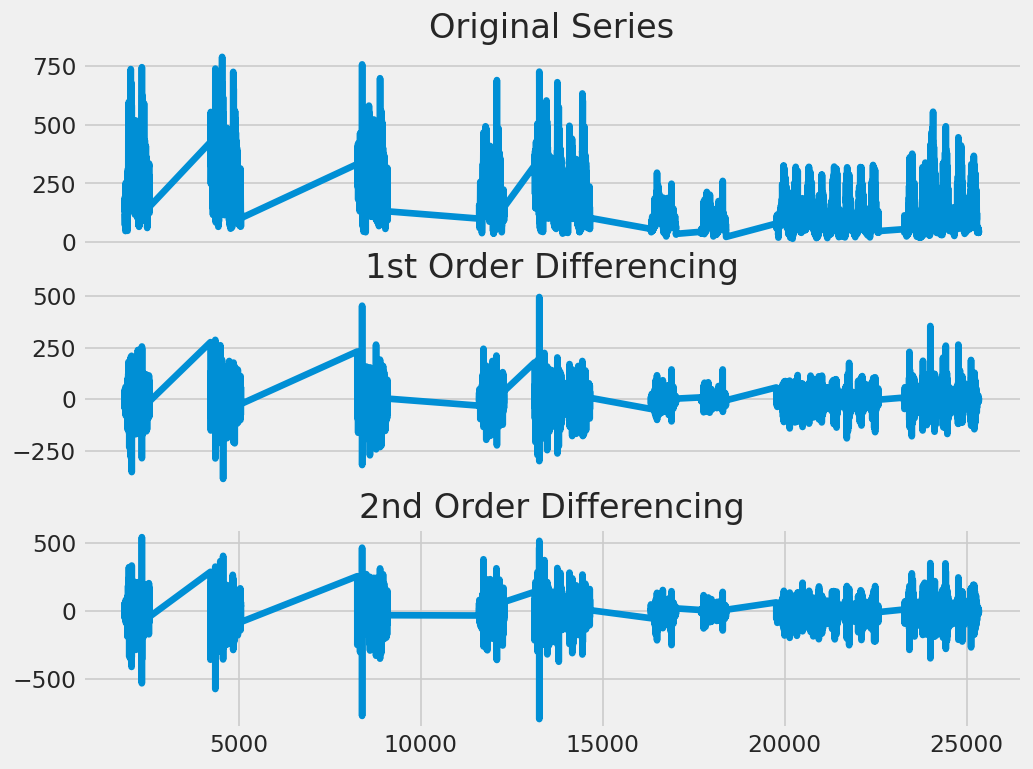

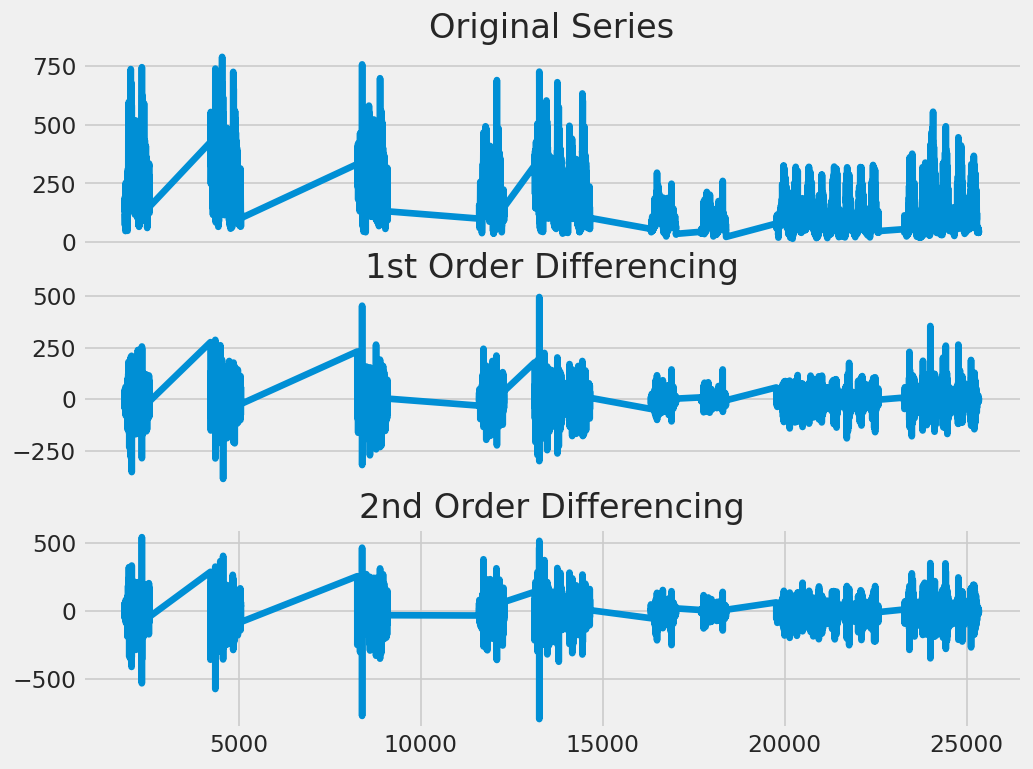

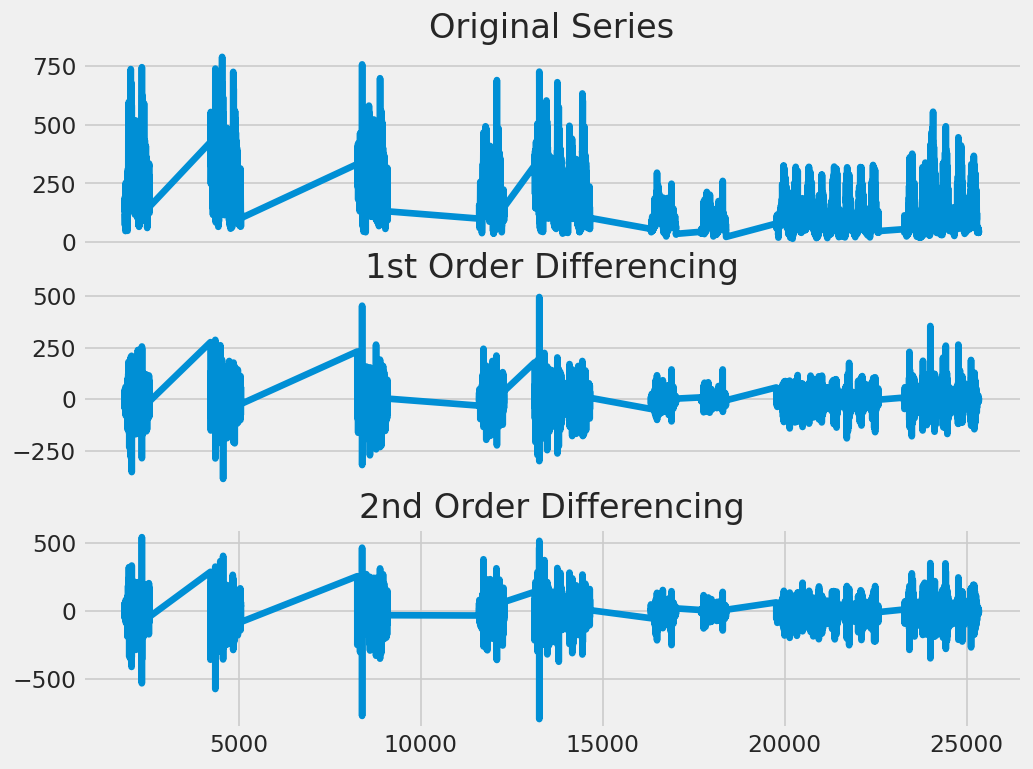

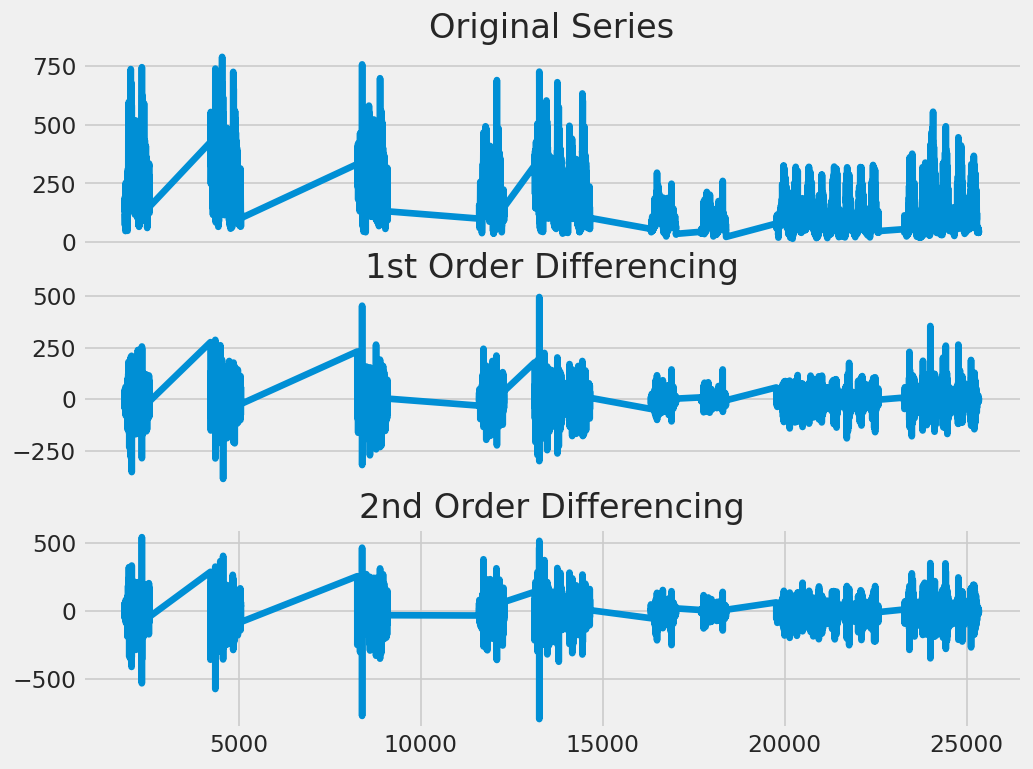

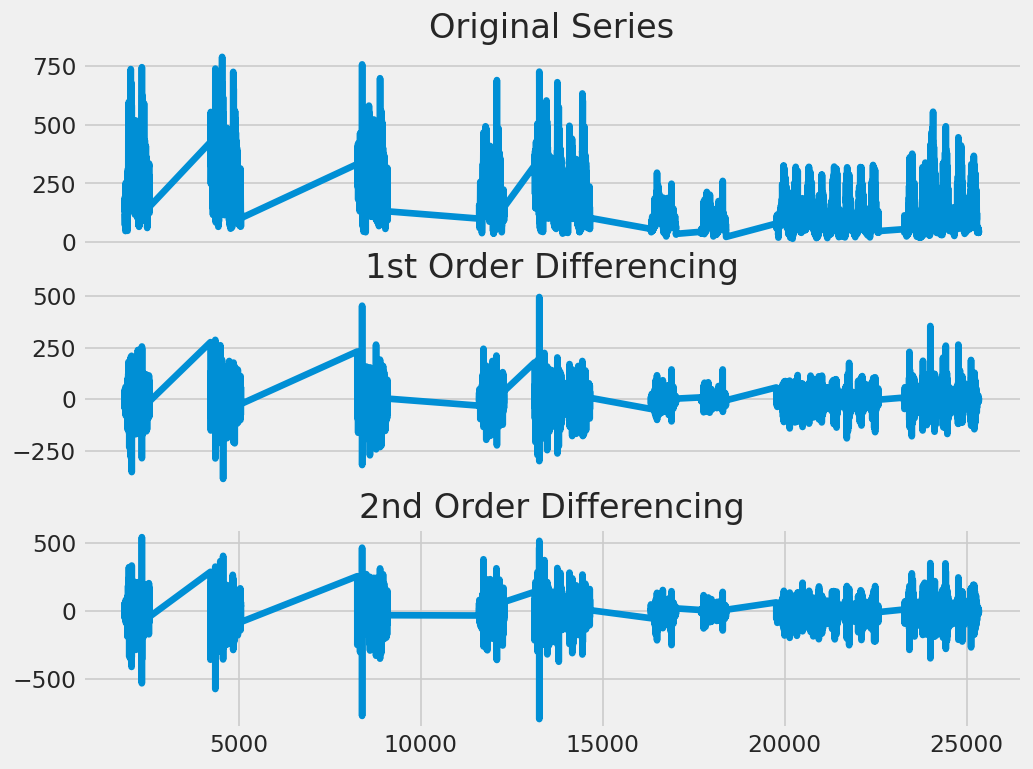

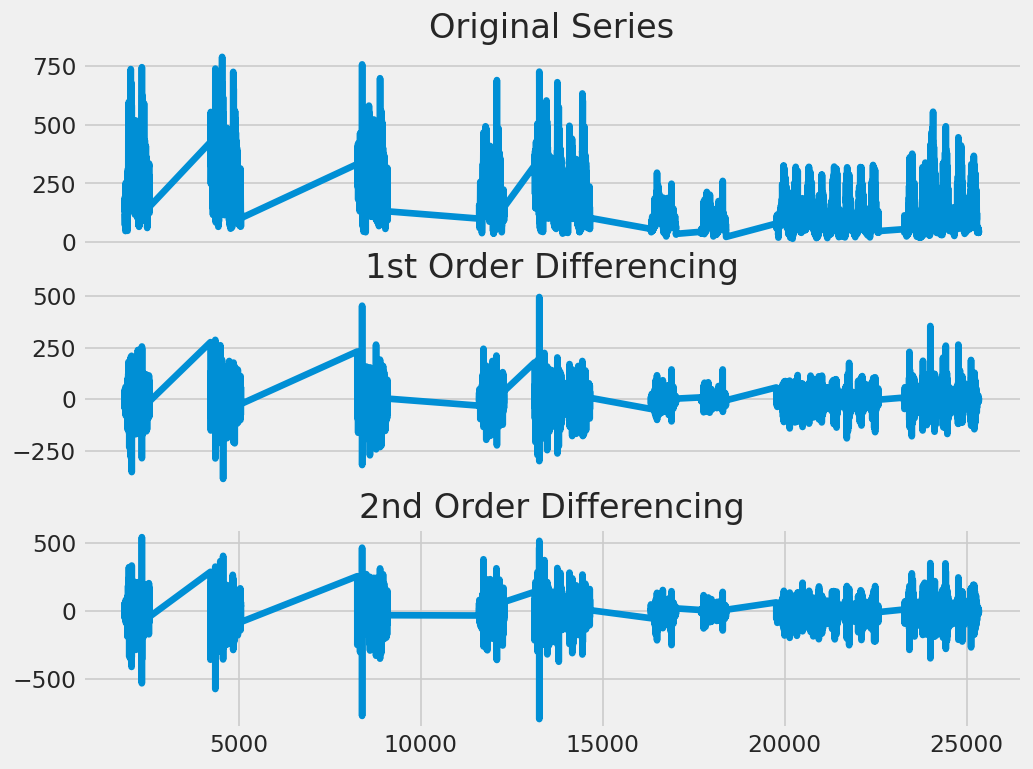

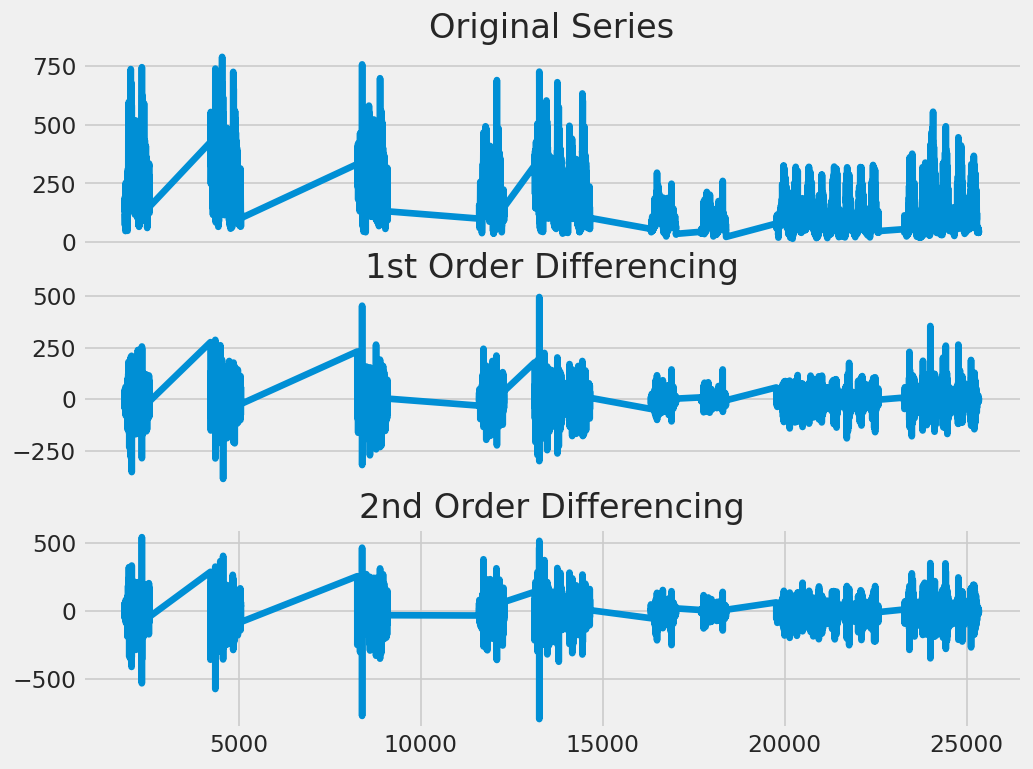

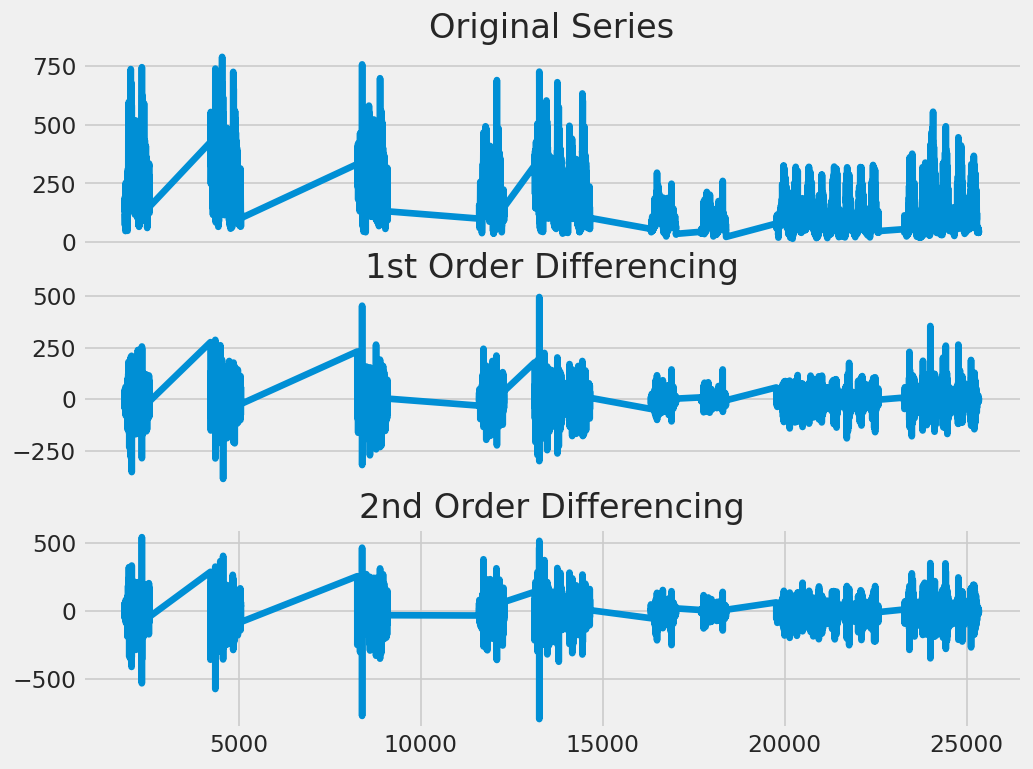

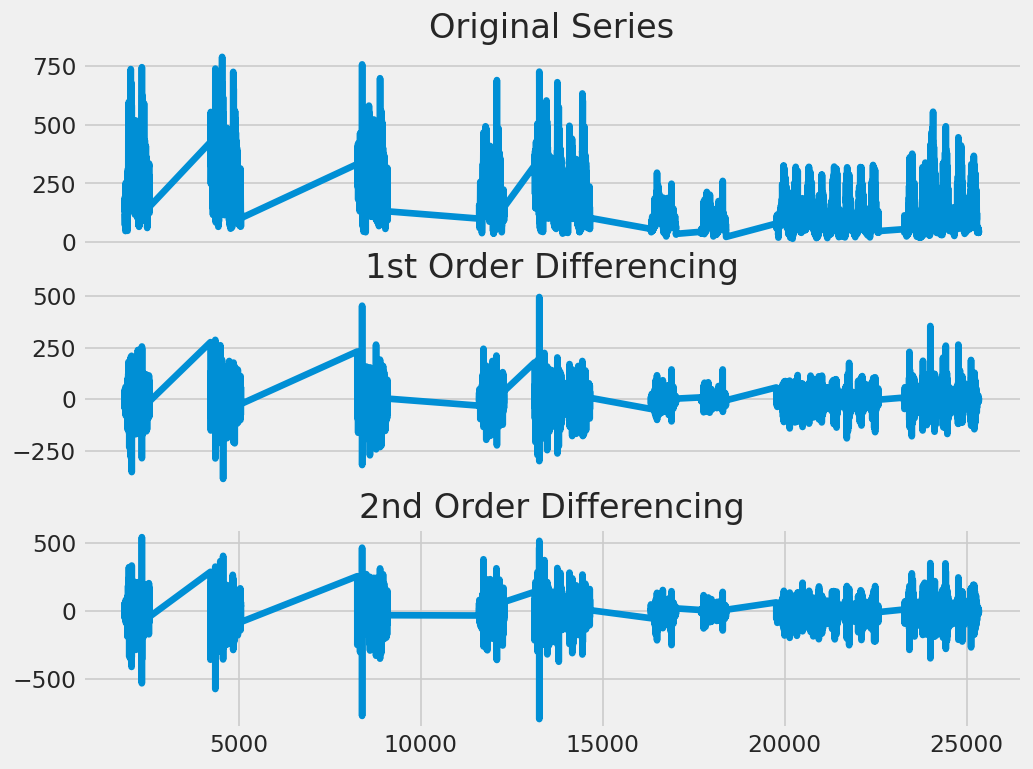

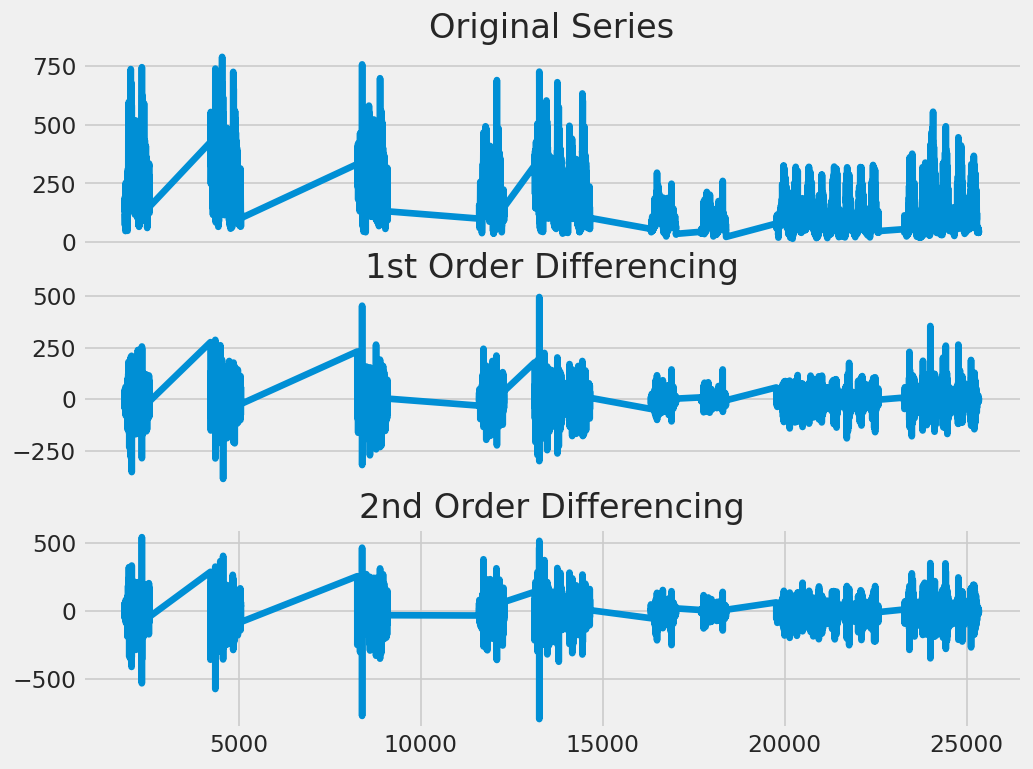

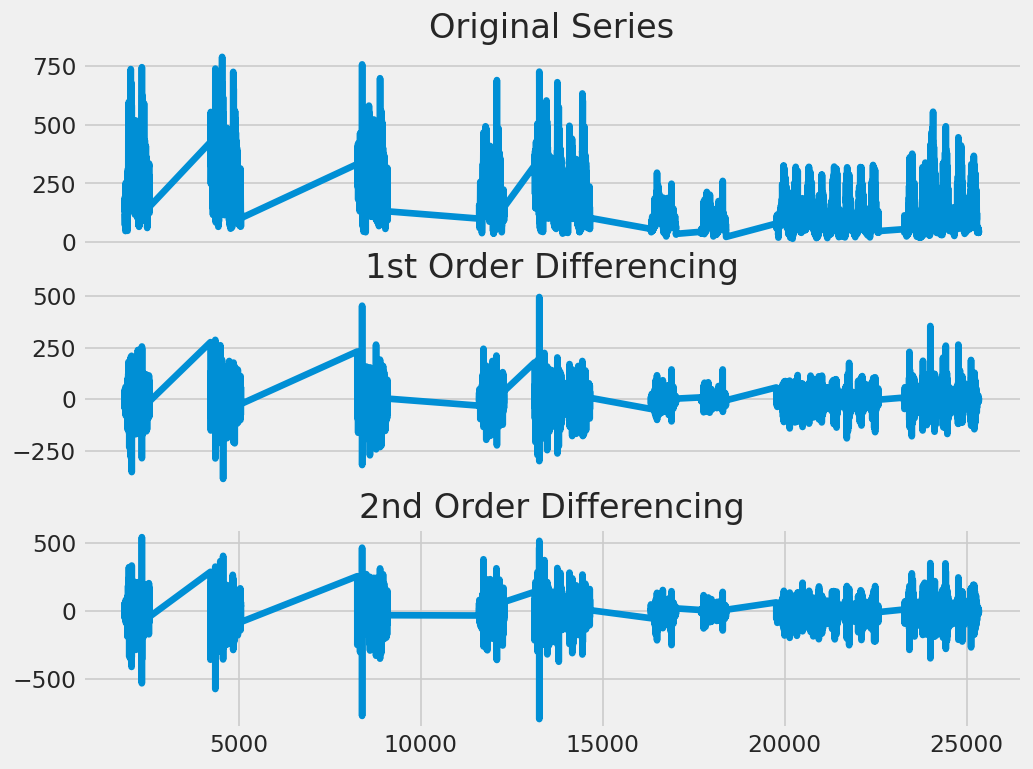

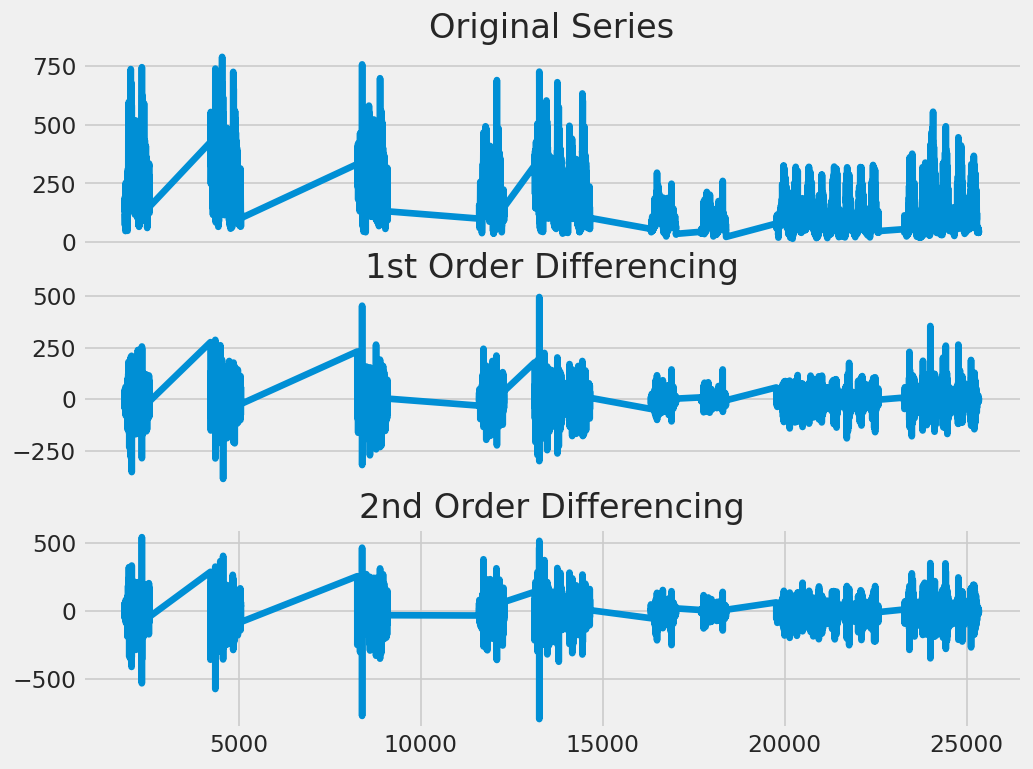

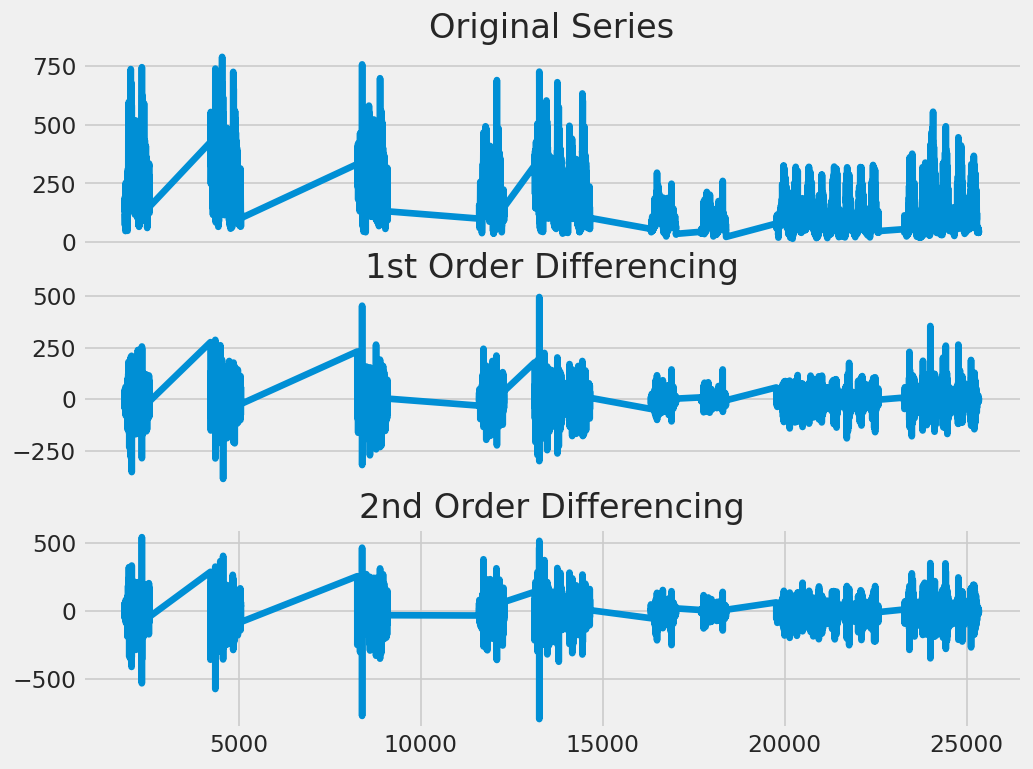

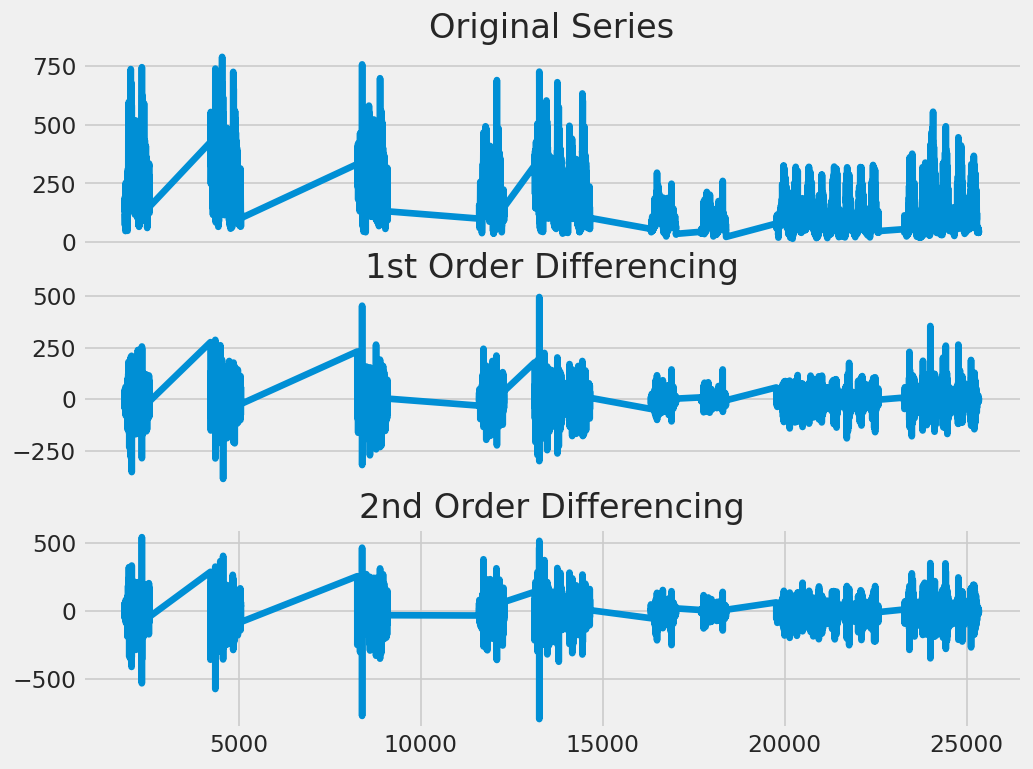

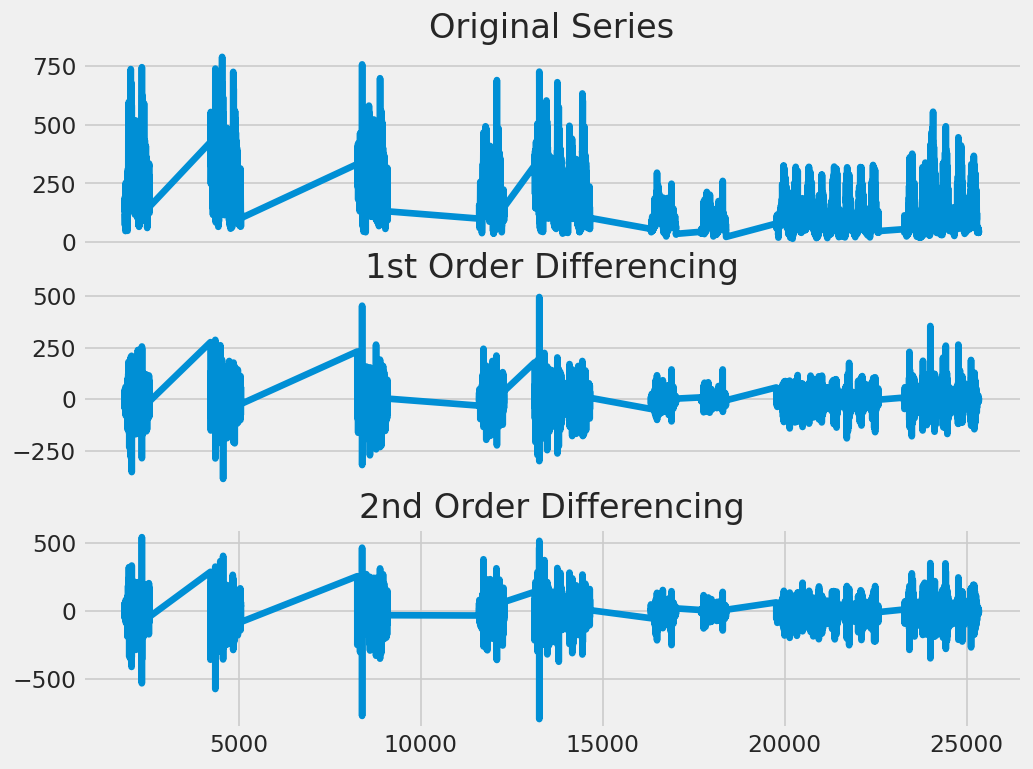

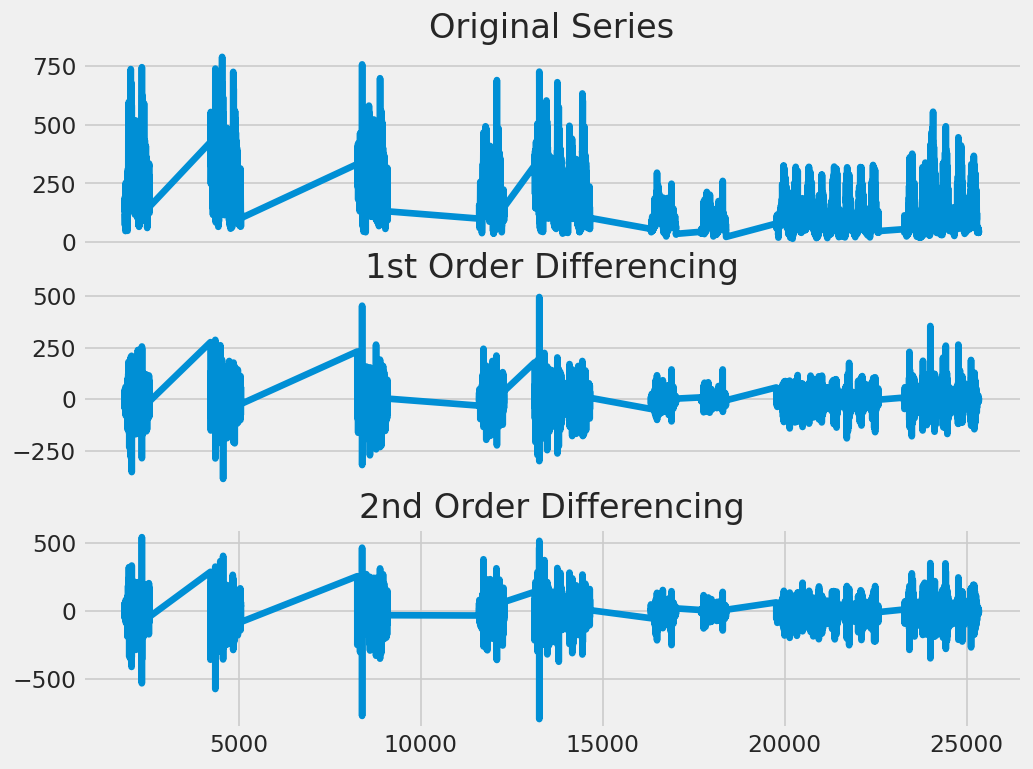

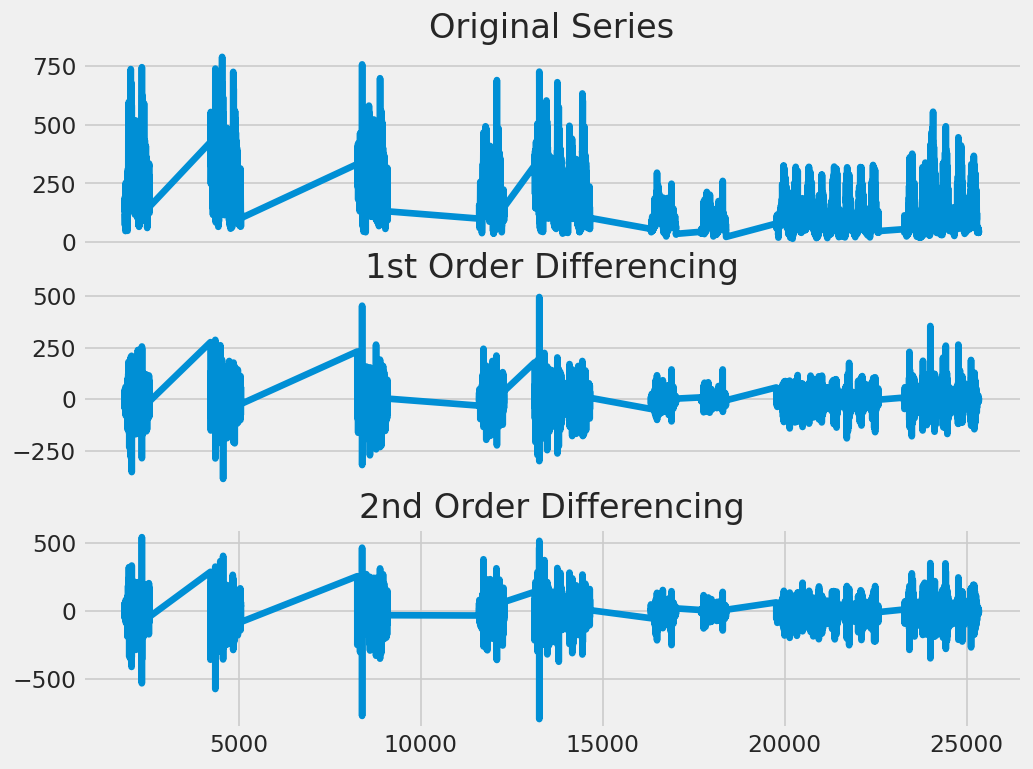

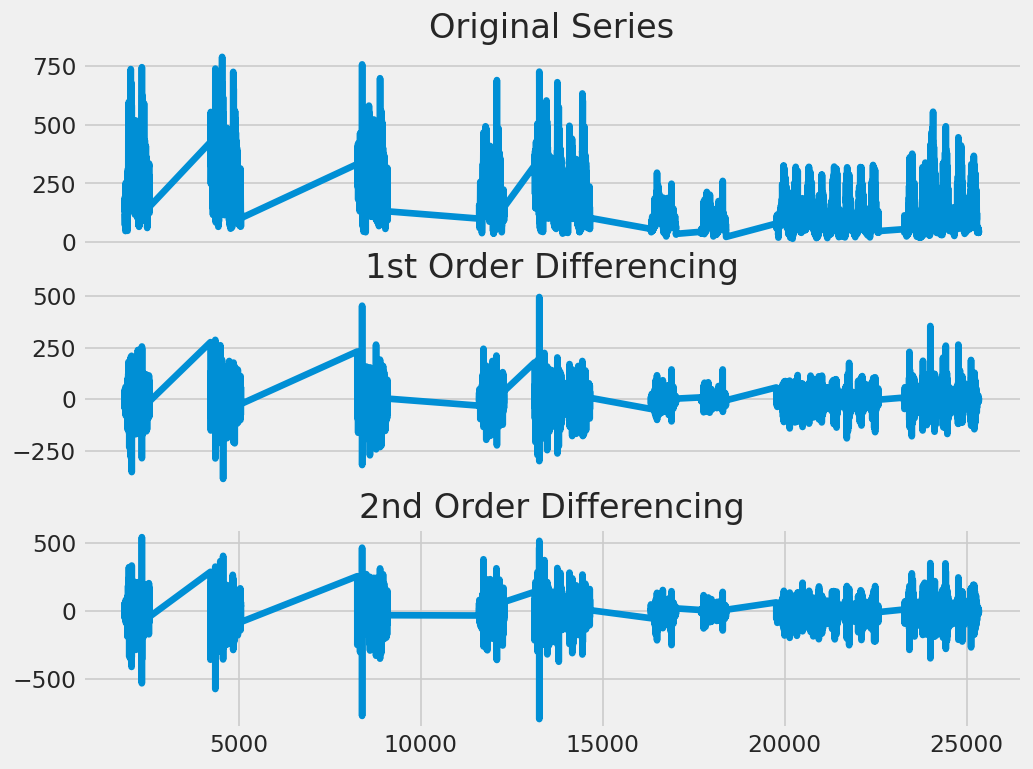

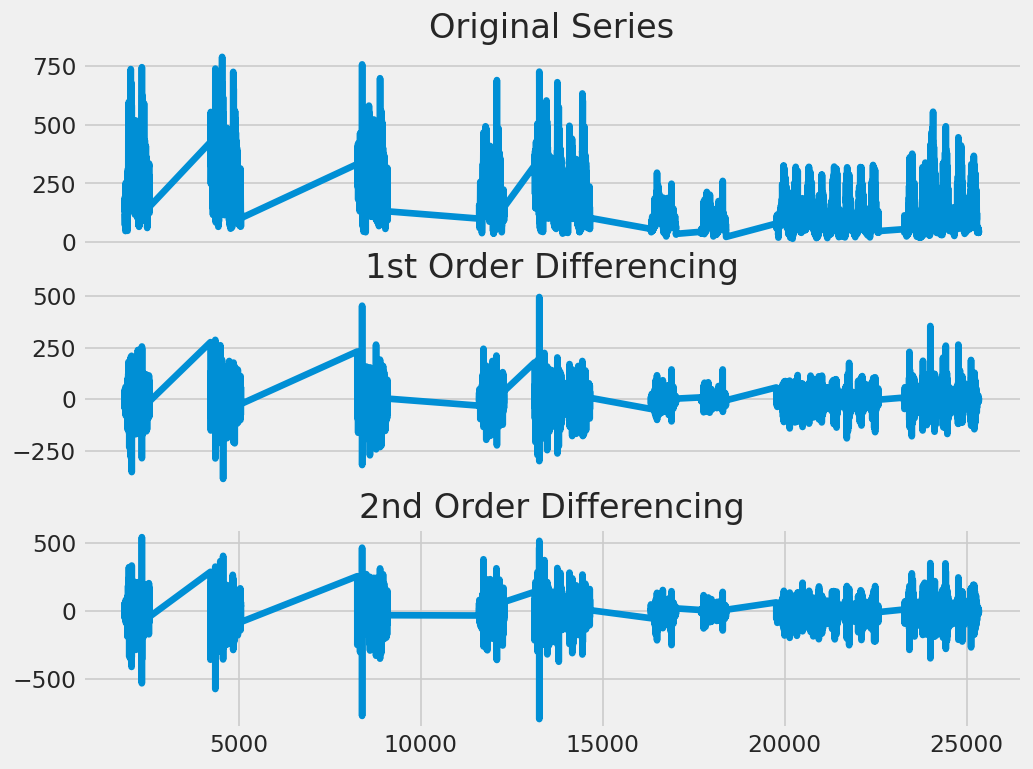

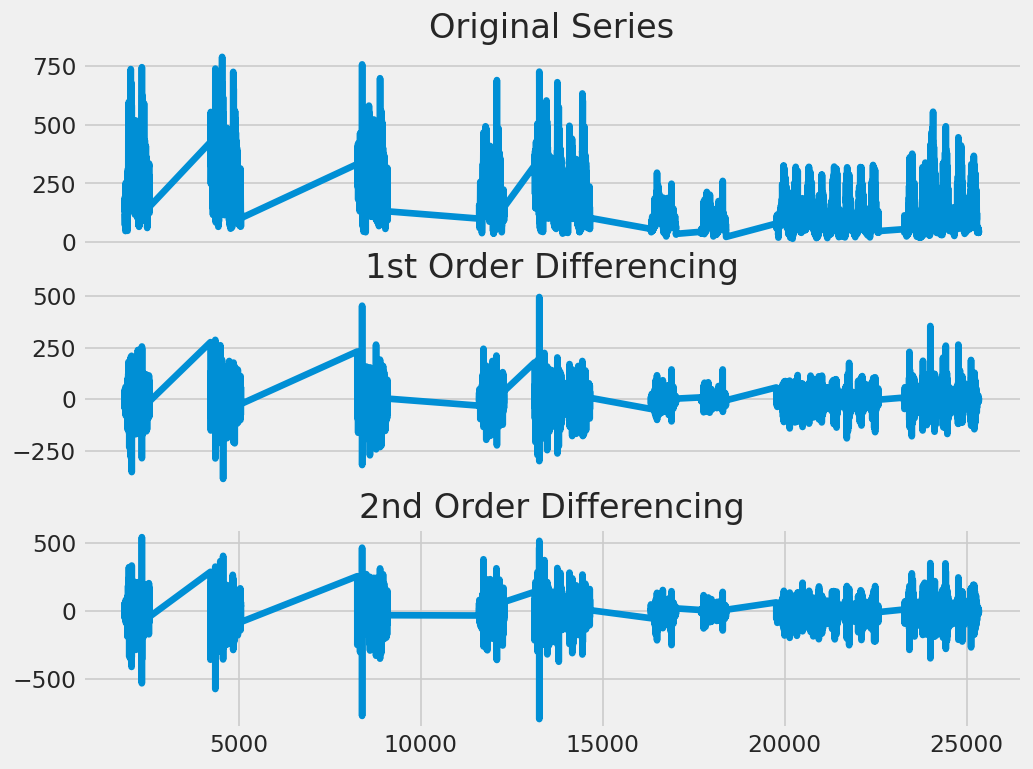

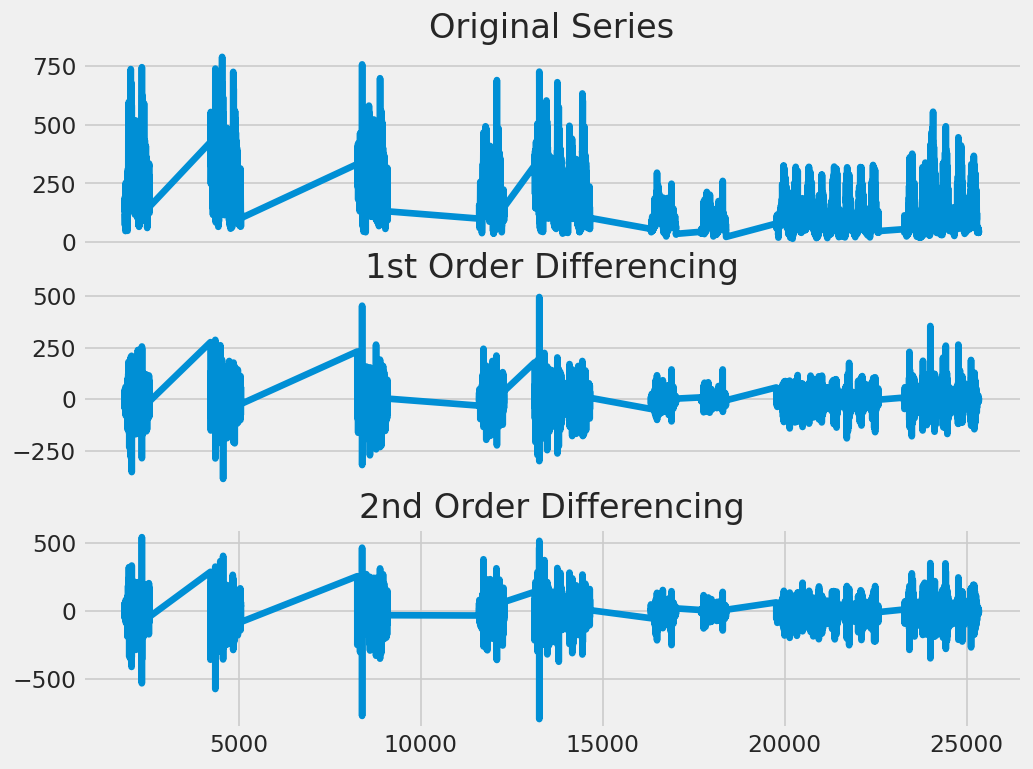

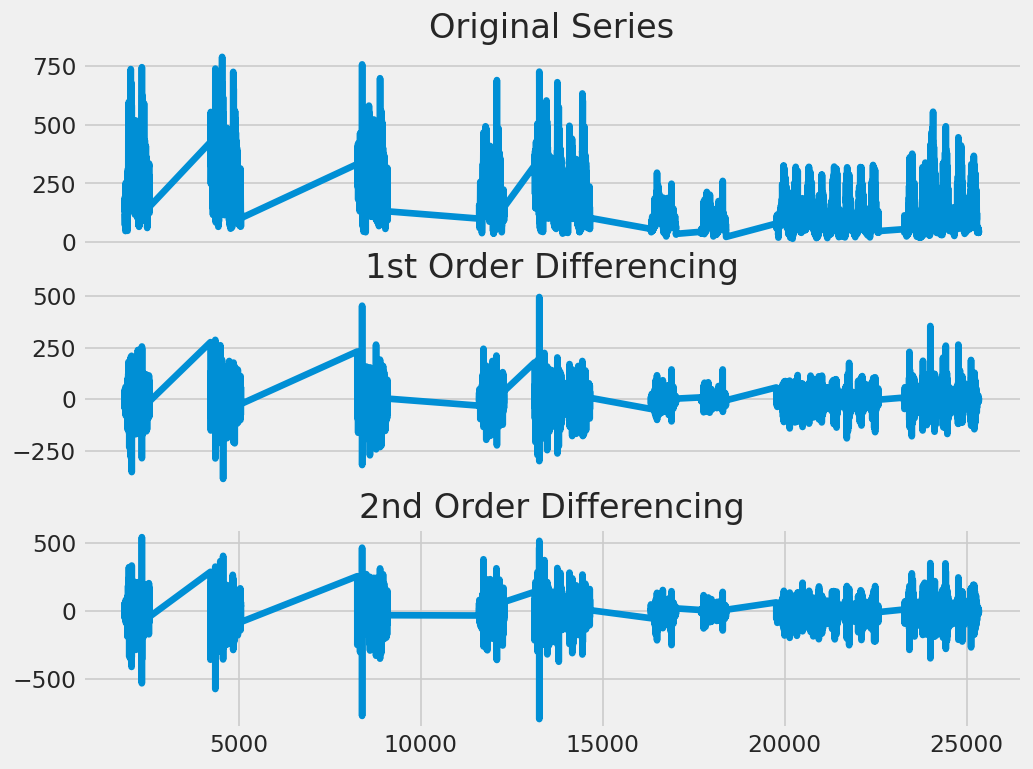

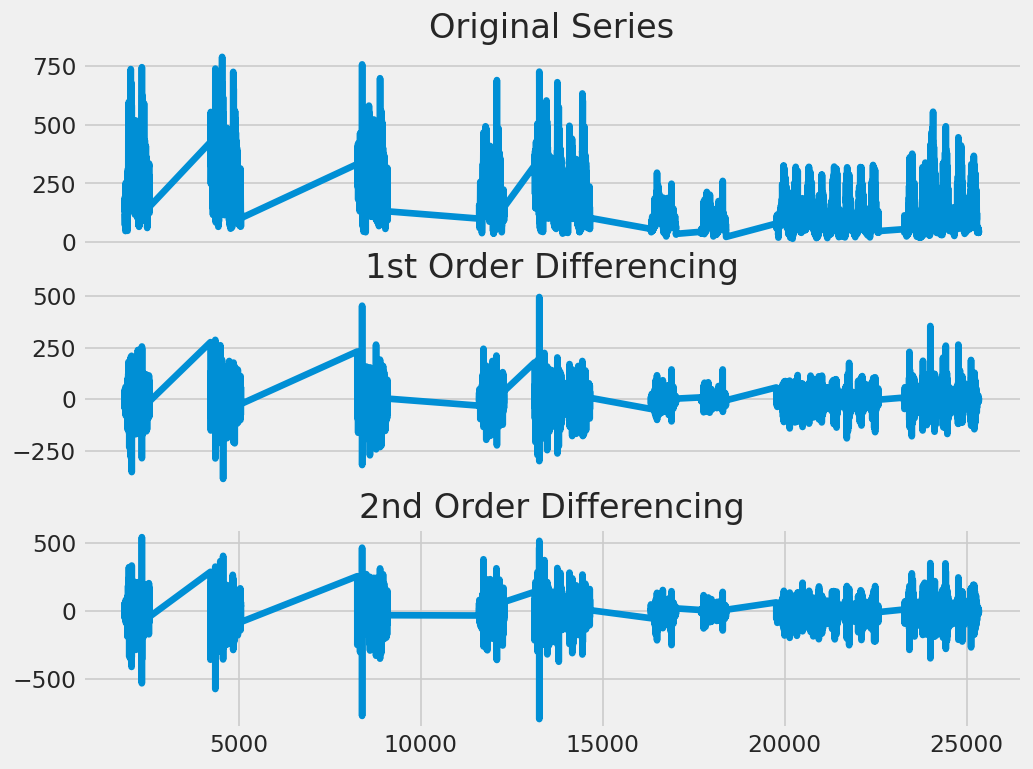

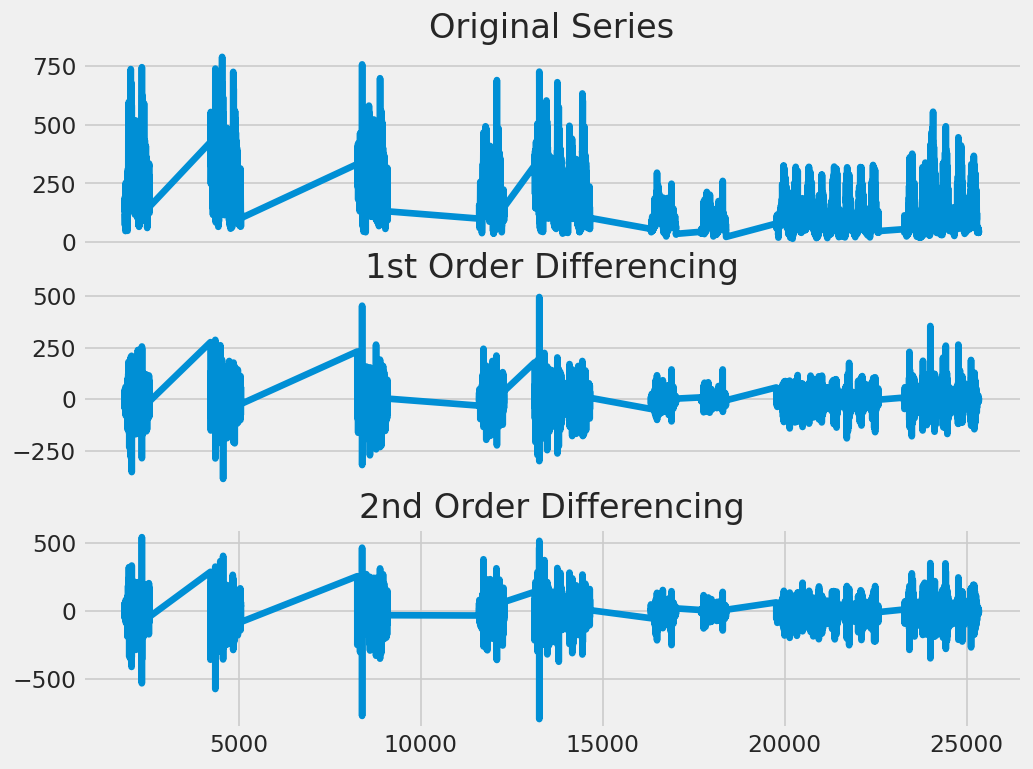

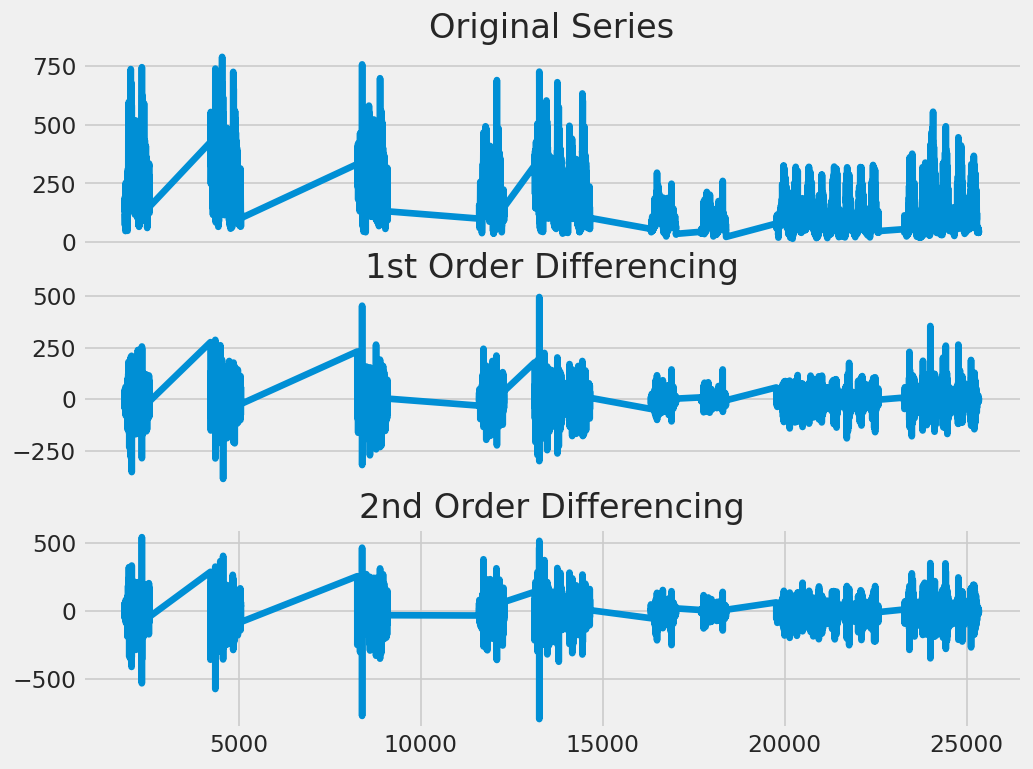

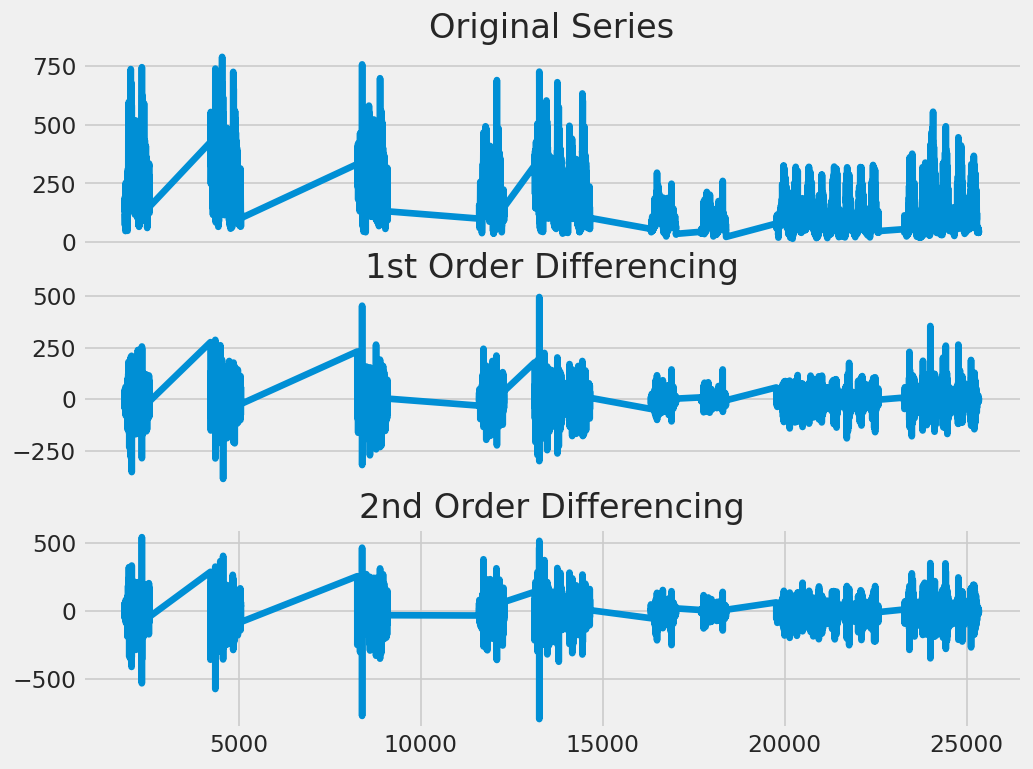

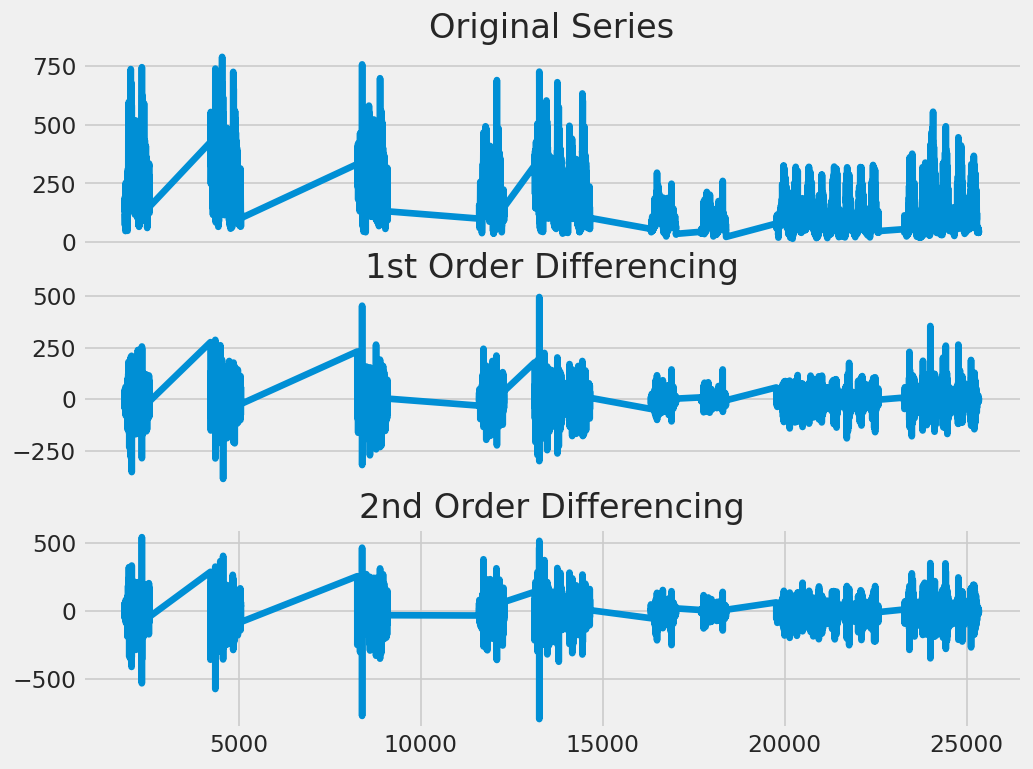

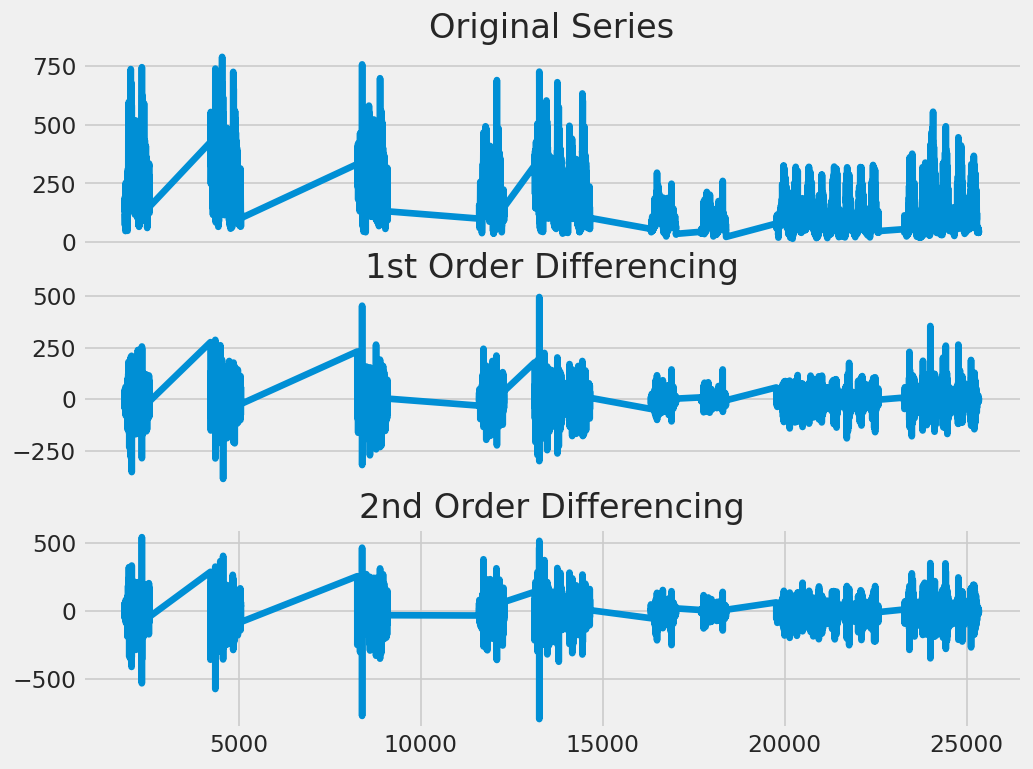

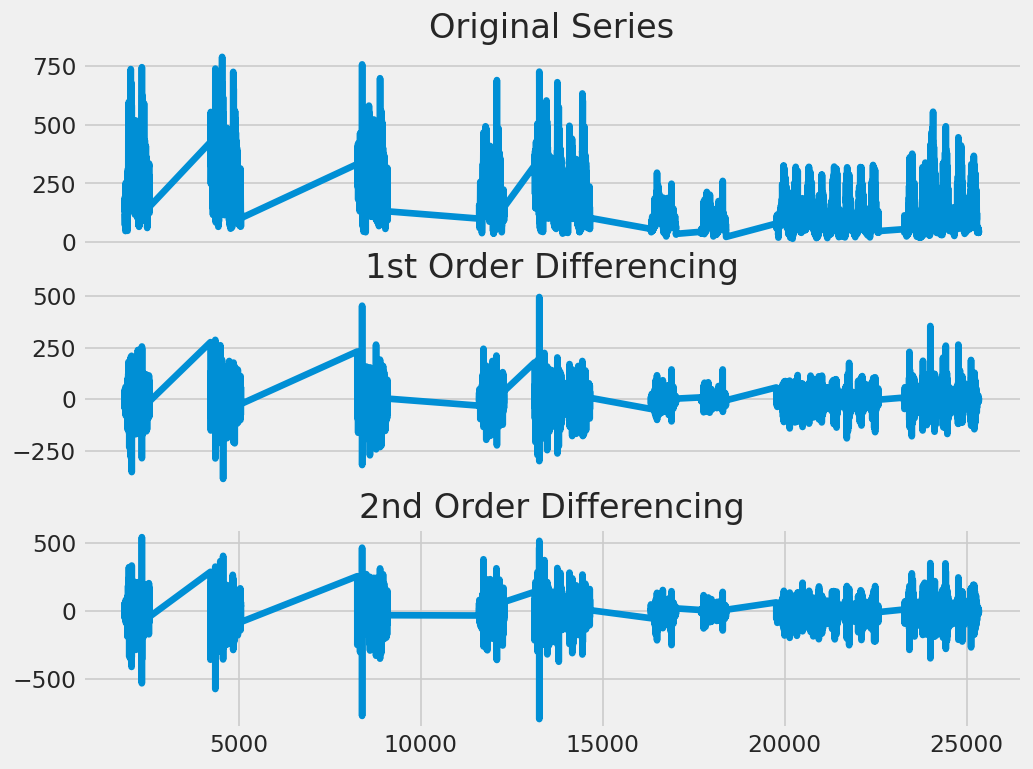

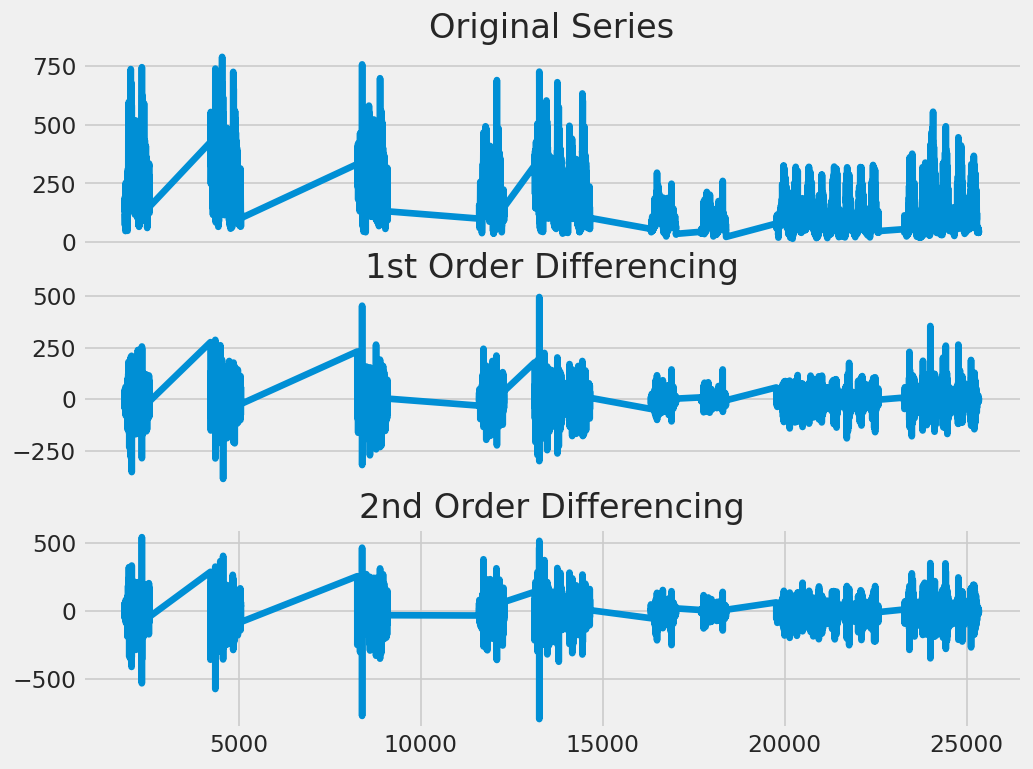

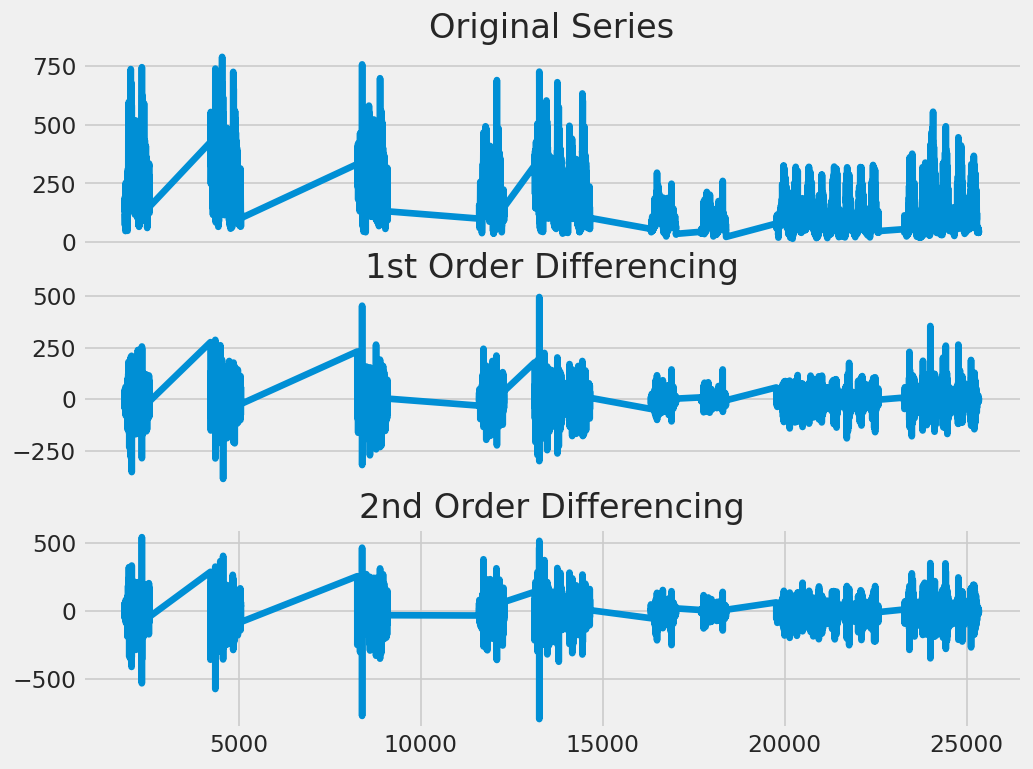

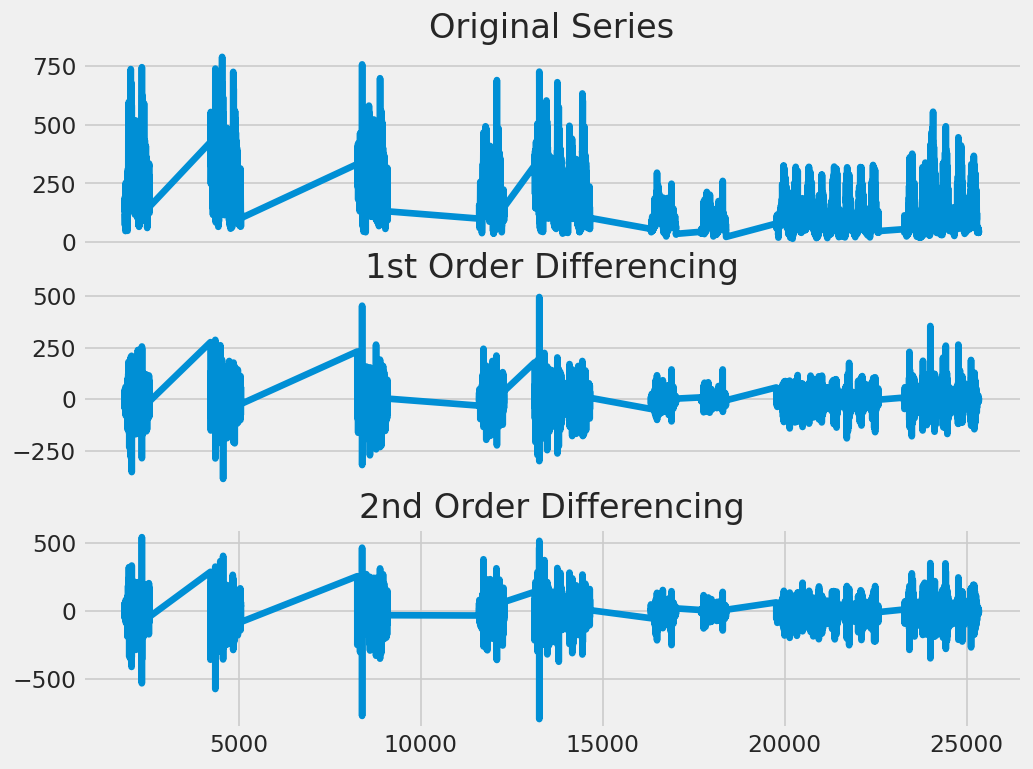

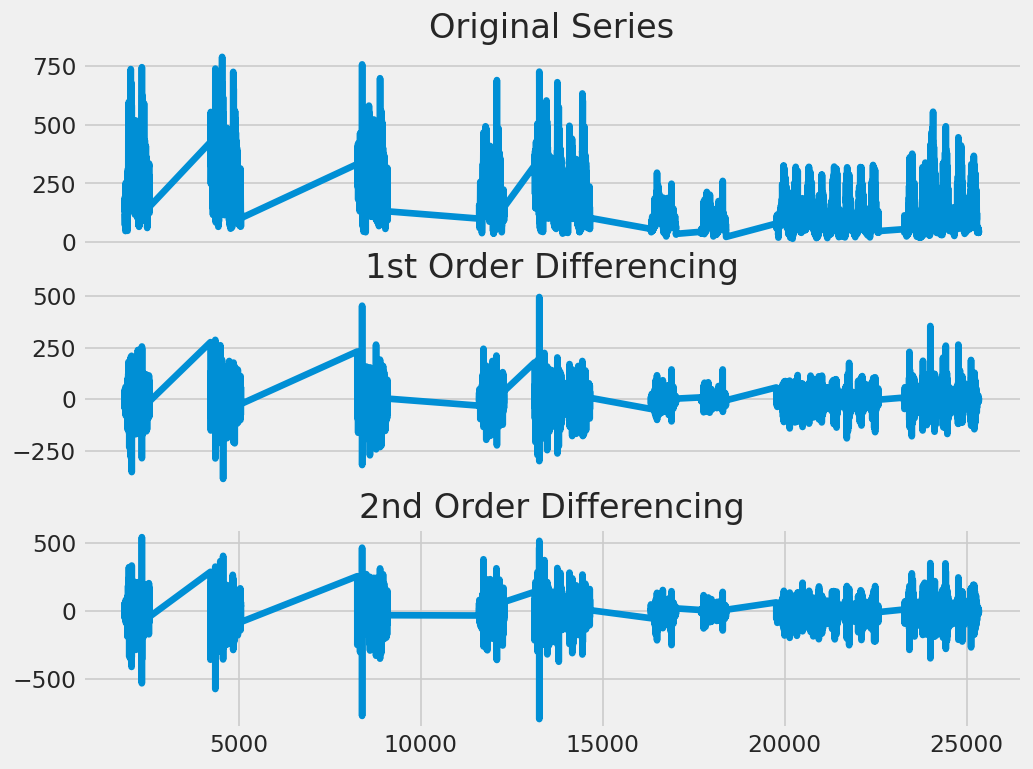

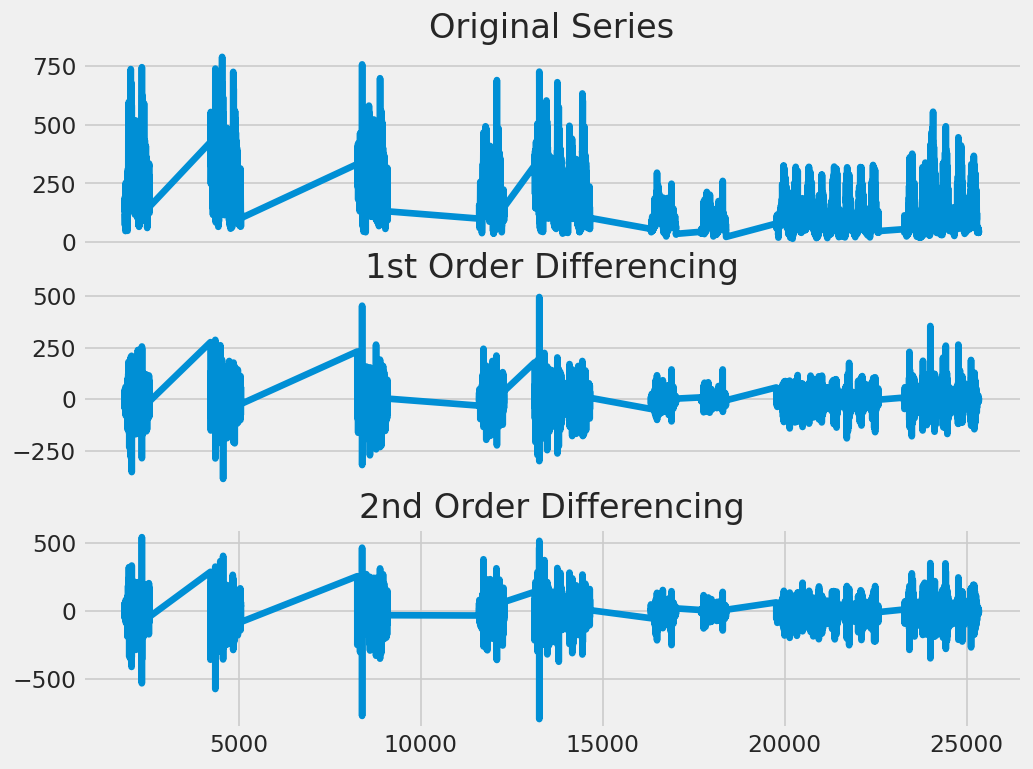

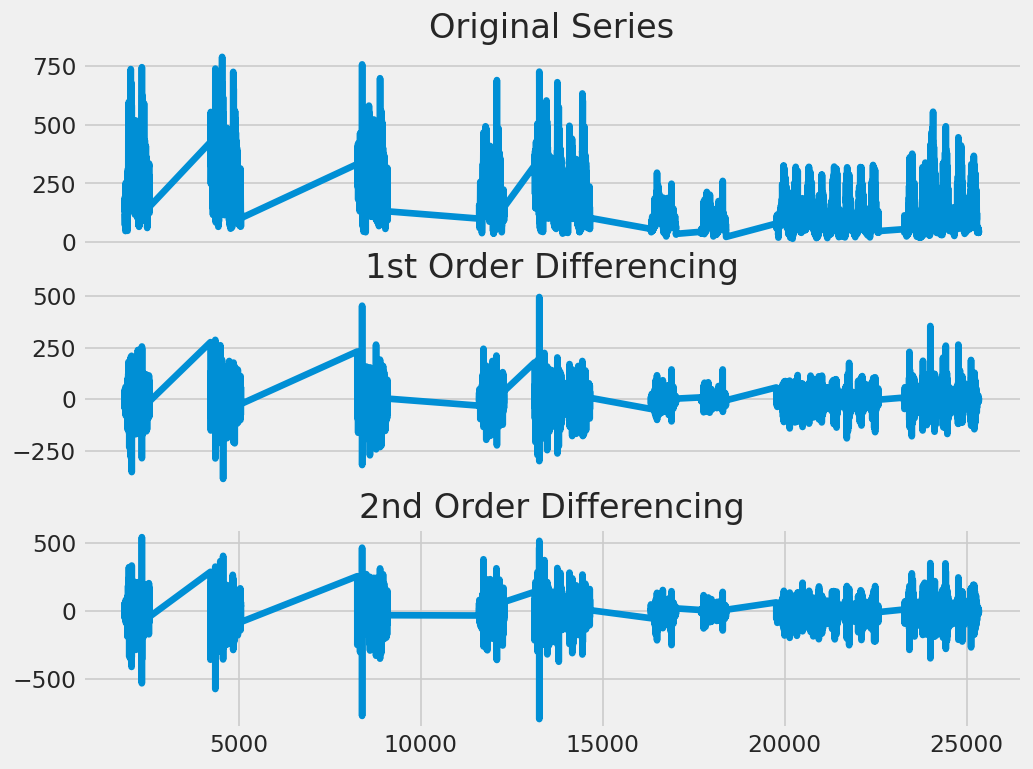

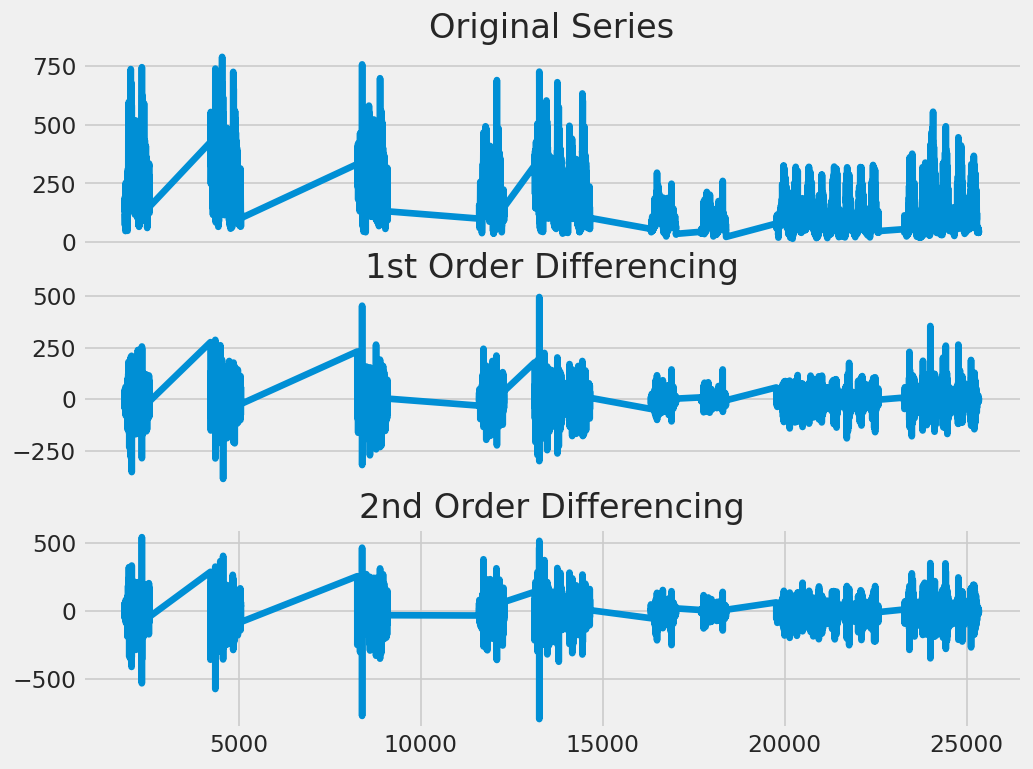

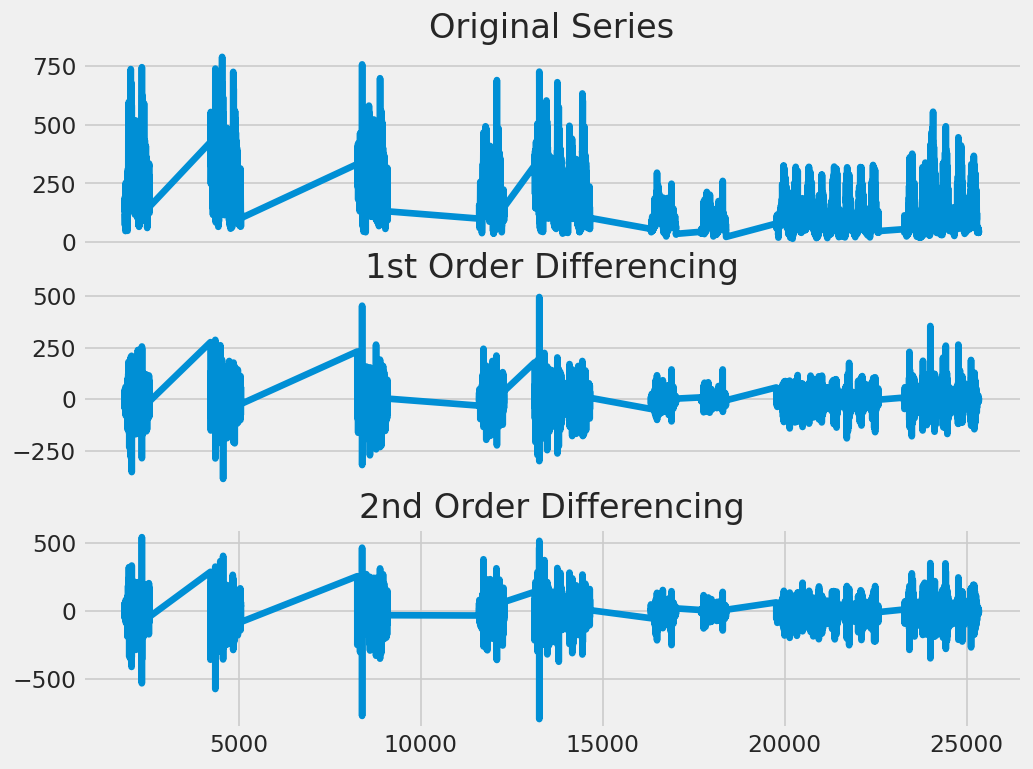

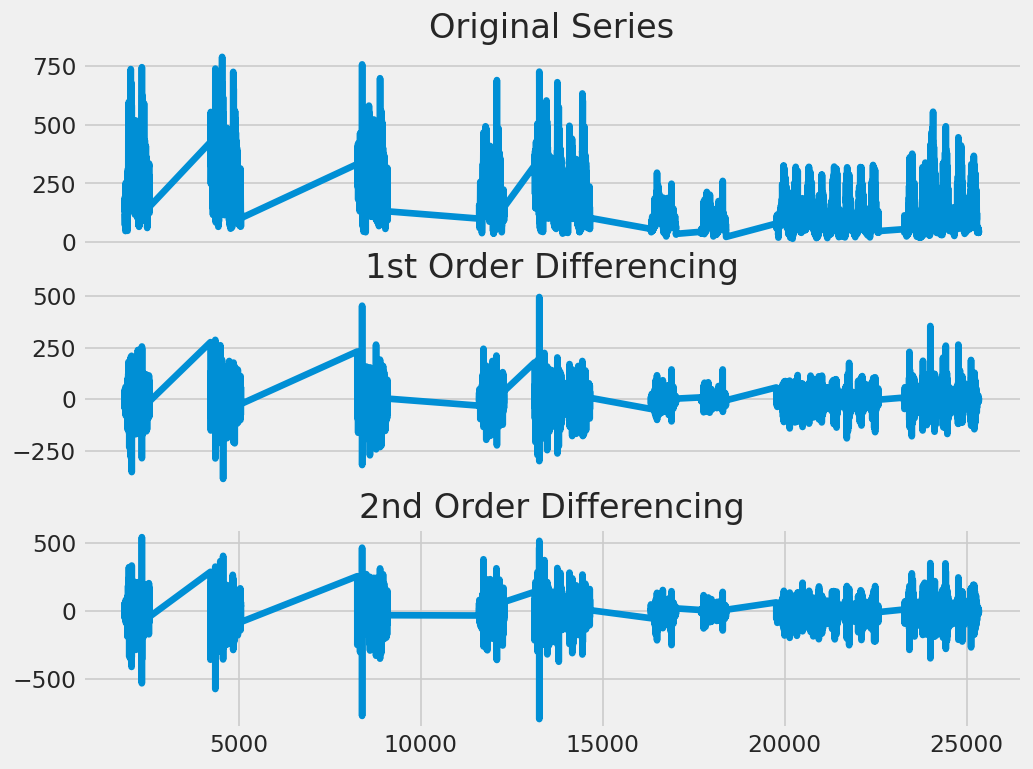

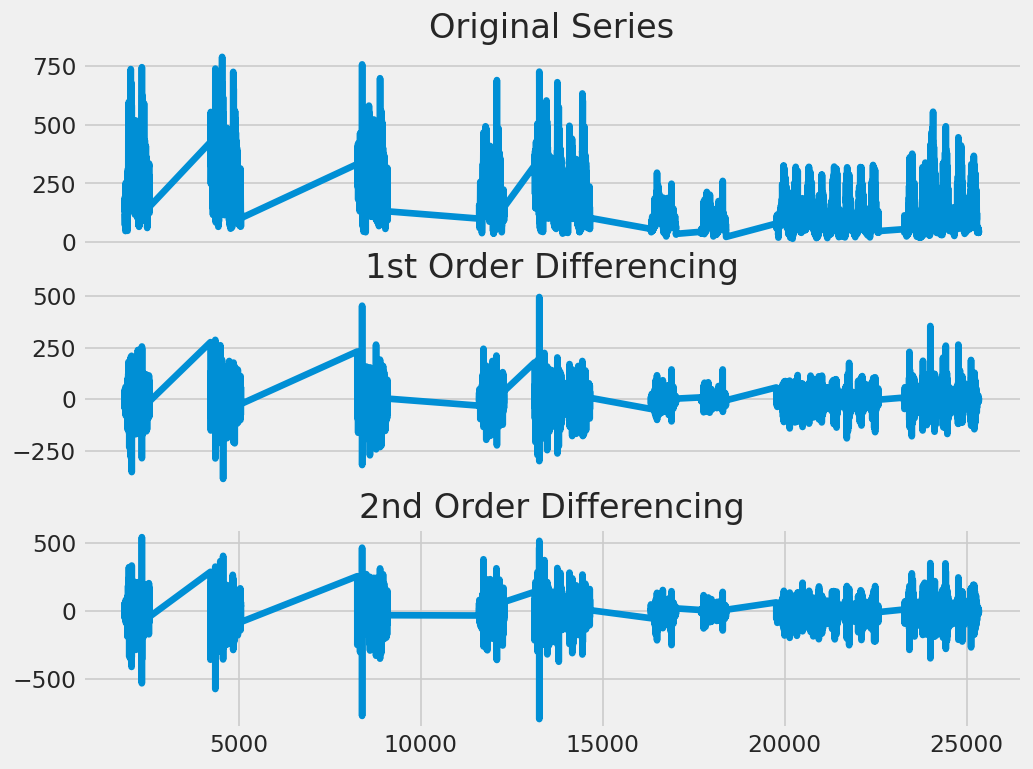

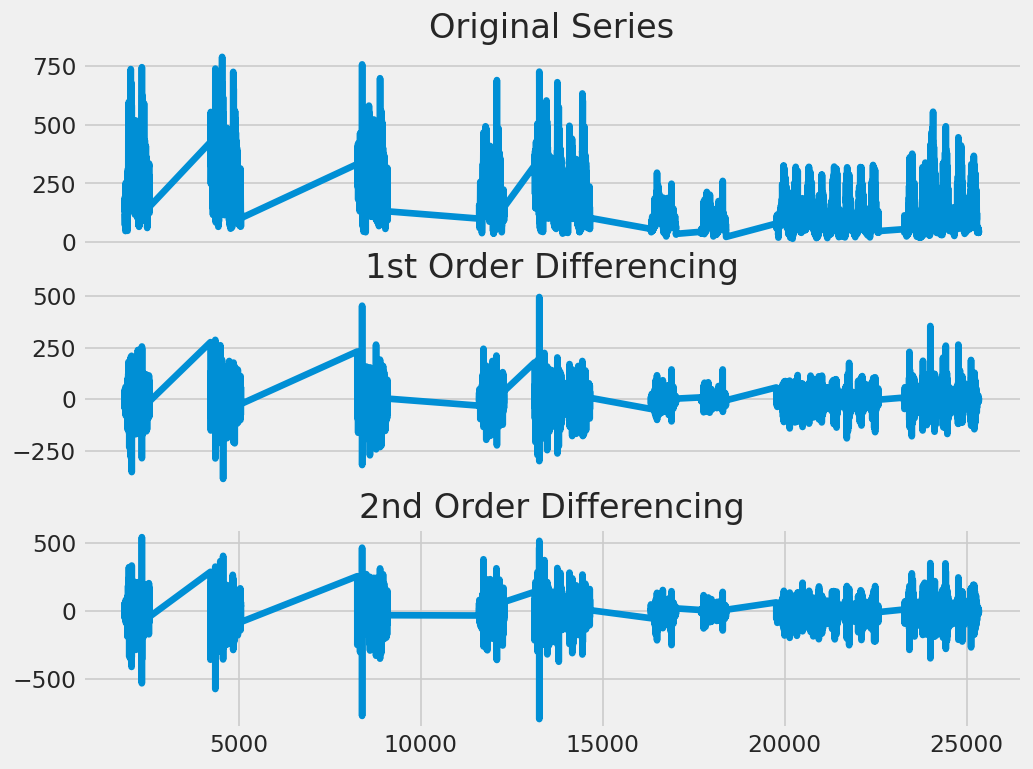

In [23]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

non_stationary_data = data[data['State_Station'].isin(non_stationary_state_station)]

for state in data['StateCode'].unique():
  state_data = data[data['StateCode'] == state]
  for station in state_data['StationId'].unique():  
    state_station_data = state_data[state_data['StationId'] == station]
    # Original Series
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    ax1.plot(non_stationary_data.AQI); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
    # 1st Differencing
    ax2.plot(non_stationary_data.AQI.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
    # 2nd Differencing
    ax3.plot(non_stationary_data.AQI.diff().diff()); ax3.set_title('2nd Order Differencing')
    plt.show()

### Model

In [25]:
def create_aqi_dict(data):
  aqi = dict()
  for state_station in data['State_Station'].unique():
    aqi[state_station] = data[data['State_Station'] == state_station][['AQI']]
  return aqi

# non_stationary_aqi = create_aqi_dict(non_stationary_data)
# stationary_aqi = create_aqi_dict(stationary_data)
aqi = create_aqi_dict(data)

res_bc = pd.DataFrame(columns=['ID_Date', 'AQI'])
pred_days = 28

# model_dict = dict()
# model_dict_new = dict()
model_dict_latest = dict()
for code, d in aqi.items():
    print(f"Working on {code} ...")
    
    # data.dropna(inplace=True)

    pipeline = Pipeline([
        ("BoxCoxTransform", BoxCoxEndogTransformer(lmbda2=1e-6)),
        # ("LogTransform", LogEndogTransformer()),
        ("model", ARIMA(order = (7,1,2), trace=False, suppress_warnings=True, n_fits=50, n_jobs=-1))
    ])

    pipeline.fit(d['AQI'])
    # model = AutoARIMA(df['AQI'], start_p=7, start_q=1, d=None, max_p=10, max_q=3, max_d=1, start_P=0, start_Q=0, D=0, max_P=0, max_Q=0, max_D=0, m=1, seasonal=True, \
    #        trace=False, error_action='warn', suppress_warnings=True, random_state = 42, n_fits=40, n_jobs=-1)
    # model = auto_arima(df['AQI'], trace=False, error_action='warn', suppress_warnings=True, n_fits=40, n_jobs=-1)
    
    # model_dict_latest[code] = model

    start_date = (data.Date.iloc[-1].date() + timedelta(days=1)).isoformat()
    end_date = (data.Date.iloc[-1].date() + timedelta(days=28)).isoformat()

    date_list = pd.date_range(start_date, end_date, freq='D')
    date_list = [code + '_' + str(day) for day in date_list]
    
    yhat = pipeline.predict(n_periods=pred_days)

    res_bc = pd.concat([res_bc, pd.DataFrame({'ID_Date': date_list, 'AQI': yhat})])
    
res_bc.reset_index(drop=True, inplace=True)

res_bc

Working on AS_4 ...
Working on DL_4 ...
Working on DL_6 ...
Working on DL_8 ...
Working on DL_12 ...
Working on DL_13 ...
Working on DL_18 ...
Working on DL_19 ...
Working on DL_21 ...
Working on DL_23 ...
Working on DL_25 ...
Working on DL_26 ...
Working on DL_27 ...
Working on DL_29 ...
Working on DL_30 ...
Working on DL_32 ...
Working on DL_35 ...
Working on DL_38 ...
Working on DL_39 ...
Working on DL_40 ...
Working on DL_41 ...
Working on KA_7 ...
Working on KA_9 ...
Working on KA_10 ...
Working on KA_11 ...
Working on KA_14 ...
Working on MH_10 ...
Working on MH_11 ...
Working on MH_12 ...
Working on MH_13 ...
Working on MH_14 ...
Working on MH_15 ...
Working on MH_16 ...
Working on MH_17 ...
Working on TN_5 ...
Working on TN_8 ...
Working on WB_12 ...
Working on WB_13 ...
Working on WB_14 ...
Working on WB_16 ...


ID_Date        AQI
0      AS_4_2022-12-04 00:00:00  58.662336
1      AS_4_2022-12-05 00:00:00  56.143129
2      AS_4_2022-12-06 00:00:00  53.554271
3      AS_4_2022-12-07 00:00:00  54.515907
4      AS_4_2022-12-08 00:00:00  53.812058
...                         ...        ...
1115  WB_16_2022-12-27 00:00:00  47.025389
1116  WB_16_2022-12-28 00:00:00  46.998816
1117  WB_16_2022-12-29 00:00:00  46.971379
1118  WB_16_2022-12-30 00:00:00  46.944954
1119  WB_16_2022-12-31 00:00:00  46.918026

[1120 rows x 2 columns]

### Saving output and model

In [26]:
res_bc.to_csv('/content/drive/MyDrive/submission.csv')

# Serialize with Pickle
# with open('/content/drive/MyDrive/arima_boxcox.pkl', 'wb') as pkl:
#     pickle.dump(pipeline, pkl)

## Summary:

The 7 in ARIMA(7,1,2) represents the number of autoregressive terms used in the model, the 1 represents the degree of differencing used to make the series stationary, and the 2 represents the number of moving average terms used in the model.
In simpler terms, ARIMA(7,1,2) tries to capture the patterns and trends in the time series data by looking at the values from 7 time periods ago and combining them in different ways with the current value.
It also takes into account the difference between consecutive values to account for any trends in the data. (Make it stationary).
Finally, it looks at the moving average of the values to smooth out any noise or fluctuations in the data.
Meaning recent values are more important than the older values which makes sense cause AQI doesn’t follow any climatic pattern and is more dependent on the current pollution levels.


Model Results
Below are the results of the models on the test (submission) data.

<hr>

| Model | Transformation Technique	| MMAE |
| :---: | :---: | :--: |
| ARIMA (7,1,2) |	BoxCox	| 28.0001
| ARIMA (7,1,2) |	LogTransform | 28.0175
| ARIMA (7,1,2) |	N/A |	28.942
| ARIMA (auto-arima) |	BoxCox	| 29.7475
| ARIMA (auto-arima) |	LogTransform |	29.4992
| ARIMA (7,1,2) |	Differencing only if not stationary	| 30.09

<hr>